# <center><strong>Advancing in player performance analysis for men’s professional football: Machine learning approaches for expected goals</strong></center>


# Introduction

In recent years the advancements in machine learning together with the convergence of enormous computational power have enabled new possibilities across various domains of our daily life. One interesting area is the domain of sports analytics, particularly football. Here machine learning algorithms can help in the quantification and assessment of both player and team performance that go beyond traditional metrics like goals, shots or possession. These traditional evaluations methods often fall short in capturing detailed contributions of both player and team quality <a href="#ref1">[1]</a>. As a consequence the development of more sophisticated metrics is pushed forward by football analysts worldwide. 

One of the most notable advancements in football analytics is the introduction of the Expected Goals (xG) metric. Expected goals are a probabilistic estimation of goal-scoring opportunities based on the likelyhood of resulting in a goal. By integrating predictors like distance, angle or opponent proximity into an machine learning models, researchers and analysts cannot only predict the expected goal values of shot but also uncover patterns, get strategic insights and the main contributing factors that lead to goals. <a href="#ref2">[2]</a> 

The goal of this thesis is to build and compare various expected goals models with different machine learning algorithms in order to identify the most robust and effective one for assessing player performance. The focus lies in examing how the model can be used for player performance analysis, particularly by comparing it to the goal contributions of players and exploring the impact of xG-values on their respective market value development. These investigations aim to contribute to the football analytics community by bridging the gap between traditional evaluation methods and the new and comprehensive insights that are offered by technologically advanced metrics like expected goals.

The dataset used for this thesis is based on publicly available data on Statsbomb and is extracting via their respective API <a href="#ref3">[3]</a>. It contains detailed records about all the relevant events that occured during the matches of the 2015/16 season, across the five top european leagues:
- Bundesliga
- Premier League
- Ligue 1
- La Liga
- Serie A

For the player performance analysis part, we use Statsbomb data from the Fifa World Cup 2022 and evaluate the corresponding players with our trained model 

# Table of content

1. [Libraries](#Libraries)
2. [Data extraction](#Data_extraction)
3. [Details of extracted data](#Details)
4. [Feature Engineering](#feature_engineering)
   - 4.1 [Distance](#distance)
   - 4.2 [Angle](#angle)
   - 4.3 [Vertical distance between shot taker and goalkeeper](#vertical_distance)
   - 4.4 [Opponent proximity](#opponent_proximity)
     - 4.4.1 [Defenders in triangle between shot location and goal posts](#triangle)
     - 4.4.2 [Number of defenders inside pressure radius](#pressure_radius)
   - 4.5 [Player position](#position)     
   - 4.6 [Transfermarkt features](#transfermarkt)
     - 4.6.1 [Strong foot/Big height](#foot/height)
     - 4.6.2 [Market value of shot taker, at the time of the shot](#value)
5. [Explanatory data analysis](#eda)     
   - 5.1 [Hexagonal plot for misses and goals](#hexplot)
   - 5.2 [Density of distance and angle](#denseplot)
   - 5.3 [Goal proportion headers and foot](#proportion)
   - 5.4 [Violin plot of distance and angle for body part](#violin)
   - 5.5 [Goal rate for strong foot and height above 185cm](#goal_rate)
   - 5.6 [Market Value vs goals](#market_value)
   - 5.7 [Temporal patterns of goals](#temporal_patterns)
   - 5.8 [Shot ratio under different number of opponents in triangle](#opponent_in_triangle)
   - 5.9 [Shot ratio under different levels of opponents in pressure radius](#opponent_in_pressure_radius)   
   - 5.10 [Count of different play patterns](#count_play_patterns)   

6. [Modelling](#modelling)
   - 6.1 [Data splitting](#splitting)
   - 6.3 [Preprocessing pipeline](#pipeline)
   - 6.4 [Final models](#models)
      - 6.4.1 [Logistic Regression](#logistic_regression)
      - 6.4.2 [Random Forest](#random_forest)  
      - 6.4.3 [XG-Boost](#xgboost)   
   - 6.5 [Model comparision](#Model_comparision)
      - 6.5.1 [Log Loss](#log_loss)
      - 6.5.2 [ROC-AUC Curve comparision](#roc_auc)    
7. [Feature Importance Analysis](#importance)
   - 7.1 [Logistic Regression](#logistic_regression_FI)
   - 7.2 [Random Forest](#random_forest_FI)
   - 7.3 [XG-Boost](#xgboost_FI) 
8. [Player performance analysis](#modelling1)
   - 8.1 [Preparing data](#loading_WC2)
      - 8.1.1 [Loading World Cup 2022 data](#loading_WC)
      - 8.1.2 [Details about data](#details_WC)  
      - 8.1.3 [Feature engineering with all features from trained mode](#FE_train)  
      - 8.1.4 [Running xgboost model on new data](#xgboost_WC_)            
   - 8.2 [Correlation between statsbomb expected goals values and our models](#xgboost_WC_)
   - 8.3 [Analysing player performance](#player_performance)
      - 8.3.1 [Players with the highest expected goals](#player_performance_1)
      - 8.3.2 [Expected goals vs players with most goals](#player_performance_12)
      - 8.3.3 [Expected goals vs players with most shots](#player_performance_123)      
      - 8.3.4 [Over and underperformance](#player_performance_3) 
      - 8.3.5 [Market value adjustments vs expected goals](#player_performance_5)    
      
      
 [References](#references) <br>   

# <strong>1 Libraries<a id="Libraries"></a><strong>

In [1]:
from statsbombpy import sb
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import json
import os
from fuzzywuzzy import fuzz
from mplsoccer import FontManager
from mplsoccer import Sbopen
from mplsoccer.pitch import Pitch
from mplsoccer.pitch import VerticalPitch
import ipywidgets as widgets
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import math
import ast
import unicodedata
from scipy.ndimage import gaussian_filter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.metrics import brier_score_loss
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
import time
import shap
from sklearn.metrics import roc_auc_score
warnings.filterwarnings('ignore')

# <strong>2 Data extraction<a id="Data_extraction"></a><strong>

We will start by extracting the desired data from the publicly available Statsbomb github repository <a href="#ref3">[3]</a>. For that we use the statsbompy library from python and store the events from all these matches inside a pandas dataframe. After that we create a final dataframe for the shots that occured during these matches. Since not all the contained columns from statsbomb are relevant for our analysis, we create a list with all the desired features and only keep those for our final shots dataframe.

In [2]:
all_competitons = sb.competitions()
BUNDESLIGA_2015_16 = sb.matches(competition_id=9, season_id=27) # Bundesliga 2015_16
LALIGA_2015_16 = sb.matches(competition_id=11, season_id=27) # La Liga 15/16
SERIE_A_2015_16 = sb.matches(competition_id=12, season_id=27) # Serie A 15/16
PREMIER_LEAGUE_2015_16 = sb.matches(competition_id=2, season_id=27) # Premier League 15/16
LIGUE_1_2015_16 = sb.matches(competition_id=7, season_id=27) # Ligue 1 15/16

all_matches = pd.concat([BUNDESLIGA_2015_16, LALIGA_2015_16, SERIE_A_2015_16, PREMIER_LEAGUE_2015_16], ignore_index=True) # combining data

# sorting the dataframe based on the time of the matches for a better overview
all_matches = all_matches.sort_values(by=['match_date', 'kick_off'])

#appending all match_ids to a list
match_ids = []
for entry in all_matches['match_id']:
    match_ids.append(entry)
    
# creating a df for all the events that occured    
all_events = pd.DataFrame()

# Looping through each match_id
for match_id in match_ids:
    # Fetching events for this match_id using the API
    events = sb.events(match_id=match_id)

    # Converting events to a DataFrame (just to be sure that everything is in a df)
    events_df = pd.DataFrame(events)

    # Adding the match_id as a column to the events DataFrame
    events_df['match_id'] = match_id

    all_events = pd.concat([all_events, events_df], ignore_index=True)
    
# adding the match_date to events because it's relevant for later    
all_events = all_events.merge(all_matches[['match_id', 'match_date']], on='match_id', how='left')

# creating final dataframe for shots without penalties
shots = all_events[(all_events["type"] == "Shot") & (all_events['shot_type'] != 'Penalty')].reset_index(drop=True) 

# List of features to keep for shots
features_to_keep_shots = ["match_id", "id", "player", "player_id", "period", "play_pattern", "position", 
                          "location", "shot_body_part", "shot_freeze_frame", "shot_outcome", "timestamp", "minute", "match_date"]
shots = shots[features_to_keep_shots]
# deleting all the shots where the body part is not head or foot (only 83 instances)
shots = shots[shots['shot_body_part'] != "Other"]


# <strong>3 Details of extracted data<a id="Details"></a><strong>

In [3]:
all_matches['total_goals'] = all_matches['home_score'] + all_matches['away_score']
average_goals_per_match = (all_matches['home_score'] + all_matches['away_score']).sum() / len(all_matches)

unique_teams = pd.concat([all_matches['home_team'], all_matches['away_team']]).unique()
number_of_teams = len(unique_teams)

print(f"Total number of different teams: {number_of_teams}")
print(f"Total number of different players: {len(shots['player'].unique())}") 
print(f"Total number of matches: {all_matches.shape[0]}")
print(f"Total number of shots: {len(shots)}")
print(f"Total number of goals: {len(shots[shots['shot_outcome'] == 'Goal'])}")
print(f"Average number of goals per match: {round(average_goals_per_match, 1)}")

Total number of different teams: 78
Total number of different players: 1741
Total number of matches: 1446
Total number of shots: 36427
Total number of goals: 3462
Average number of goals per match: 2.7


# <strong>4 Feature Engineering<a id="feature_engineering"></a><strong>

# 4.1 Distance<a id="distance"></a>

The distance is calculated as the euclidean distance between shot location and the center of the goal.

In [4]:
def calculate_distance_to_goal(coordinates):
    
    x_coordinate, y_coordinate = coordinates

    # The goal is located at x = 120
    x_dist = 120 - x_coordinate

    # The center of the pitch is at y = 40
    y_dist = abs(y_coordinate - 40)

    distance = math.sqrt(x_dist**2 + y_dist**2)

    return distance
    
shots['shot_distance'] = shots['location'].apply(calculate_distance_to_goal)

# 4.2 Angle<a id="angle"></a>

The angle is derived by using the arctangent function and calculating the angle in degrees between the shot location and the two goal posts. The only time this formula is not appliable is when $x$ and $y$ is 116 and 40 (dividing by 0). In those cases (which is only one in the data) we decided to adjust the $x$ coordinate of the shot by a very small epsilon value, so that you never didvide by 0. The angle calculation is based on the formula from David Sutter <a href="#ref4">[4]</a>.

In [5]:
def calculate_angle(coordinates):
    x, y = coordinates
    width = 8  # Width of the goal
    goal_x = 120  # x-coordinate of the goal line
    goal_y = 40  # y-coordinate of the middle of the pitch
    epsilon = 1e-5 # incase the shot location is 116, 40 
    if x == 116 and y == 40: # dividing by 0 is not possible so we increase x by epsilon. There is only 1 instance of that special case in the data  
        x+=epsilon
        y+=epsilon

    # Applying the given formula
    angle = np.arctan(width * (goal_x - x) / ((goal_x - x)**2 + (goal_y - y)**2 - (width / 2)**2))  # calculating angle in radians
    if angle < 0: # adjusting negative angles 
        angle = np.pi + angle

    # Converting the angle to degrees
    angle_degrees = np.degrees(angle)
    return angle_degrees

shots['shot_angle'] = shots['location'].apply(calculate_angle) 

# 4.3 Vertical distance between shot taker and goalkeeper<a id="vertical_distance"></a>

We will continue by creating two features. The first one is for determining the vertical distance between the shot taker and the goalkeeper. This can have very important implications on how important the positioning of the goalkeeper is and how challenging a shot for the goalkeeper can be given the vertical distance. Since the horizontal position of the shot taker can be higher than the one of the goalkeeper we also define a boolean variable called "is_past_goalkeeper".

In [6]:
def vertical_distance_gk_shot_location_and_past_gk(shot, shots_df):
    try:
        shot_id = shot['id']
        freeze_frame_data = shots_df.loc[shots_df['id'] == shot_id, 'shot_freeze_frame'].values
        goalkeeper_position = next(player['location'] for player in freeze_frame_data[0]
                                   if player['position']['name'] == 'Goalkeeper' and not player['teammate'])

        # Calculate vertical distance
        distance = abs(shot['location'][1] - goalkeeper_position[1])

        # Determine if the shot is past the goalkeeper
        is_past_gk = shot['location'][0] > goalkeeper_position[0]

        return distance, is_past_gk
    
    except: # incase there is no goalkeeper in the shot freeze frame
        return None, None

shots[['vertical_distance_to_gk', 'is_past_goalkeeper']] = shots.apply(lambda x: vertical_distance_gk_shot_location_and_past_gk(x, shots), axis=1, result_type='expand')

# 4.4 Opponent proximity<a id="opponent_proximity"></a>

In this section we will implement to different features that are based on opponent proximity:
- Number of defenders in the triangle that is formed between shot location and the two goalposts
- Number of defenders in a pressure radius that is based on the shot distance

The main goal with the implementation of those features is to enhance the predictability by capturing defensive pressure and the available space for placing a shot.

## 4.4.1 Defenders in Triangle of shot location and goal posts<a id="triangle"></a>

We start by defining a triangle where the three points are formed via the shot location and the two goal posts. Then the number of opponent players in the resulted triangle will be counted by using the cross product formula in relation to each vertex of the triangle. The idea for counting whether a player is inside the triangle is based on David Sutters and Aleksander Andrzejewskis approach <a href="#ref5">[5]</a>.

In [7]:
def opponents_triangle(shot, shots_df):
    freeze_frame_data = shots_df.loc[shots_df['id'] == shot["id"], 'shot_freeze_frame'].values
    
    # Extracting opposition player locations
    player_positions = [player['location'] for player in freeze_frame_data[0] if not player['teammate']]

    # triangle vertices
    x1, y1 = 120, 36  # Top right post
    x2, y2 = 120, 44  # Bottom right post
    x3, y3 = shot["location"]

    # Counting players inside the triangle by calculating cross product of vectors that are formed by the vertices of the triangle
    count = 0
    for xp, yp in player_positions: # xp and yp are the player coordinates of the player positions
        c1 = (x2 - x1) * (yp - y1) - (y2 - y1) * (xp - x1) # 1) vertices of triangle
        c2 = (x3 - x2) * (yp - y2) - (y3 - y2) * (xp - x2) # 2) vertices of triangle
        c3 = (x1 - x3) * (yp - y3) - (y1 - y3) * (xp - x3) # 3) vertices of triangle
        if ((c1 <= 0) & (c2 <= 0) & (c3 <= 0)) or ((c1 >= 0) & (c2 >= 0) & (c3 >= 0)): # when all the cross products have the same sign: player is inside triangle
            count += 1

    return count

shots['opponents_in_triangle'] = shots.apply(lambda row: opponents_triangle(row, shots), axis=1) 

## 4.4.2 Number of defenders inside pressure radius<a id="pressure_radius"></a>

For this feature we want to see how defensive pressure from front and behind impacts the goal probability. Therefore we define a pressure radius around the shot taker that changes based on shot distance. Concretely the further a player is away from goal the bigger the radius gets and vice versa. We start by defining the center of the circle which is the shot location. The idea for that is from the Statsbomb article from Derrick Yam <a href="#ref6">[6]</a> 

For defining the radius of the cycle I tried several different approaches and decided to go with the following technique: I logarithmize the shot distance with the natural logarithm and then multiple it with the factor of 2 to get a reasonable big and not too small radius. Furthermore I set boundaries for the min and max radius. With this method we achieve a comprise between a realistic pressure radius that decreases with shot distance and doesn't become to small either. To check wether an opponent falls within the circle I calculate the distance of the opponents from the center of the circle (which is the shot location) and then compare the distance with the radius of the circle. If the distance from a defender is less or equal to the radius, then the point is inside the circle, otherwise it is outside. If an opponent is in the circle, we check whether he is behind or infront of the defender.

In [8]:
def opponents_circle(shot, shots_df):
    freeze_frame_data = shots_df.loc[shots_df['id'] == shot["id"], 'shot_freeze_frame'].values[0]
    player_positions = [player['location'] for player in freeze_frame_data if not player['teammate']]
    
    
    x0, y0 = shot["location"]
    min_radius = 1  # Minimum allowable radius, so that the circle doesn't get too big or small
    max_radius = 6  # Maximum allowable radius, so that the circle doesn't get too big or small
    r = np.clip((2*np.log(shot["shot_distance"] + 1)), min_radius, max_radius) # approach for getting the radius of the cycle 
    # adding 1 to the distance incase the distance is 0 (log(0)) and to increase the size of the circle 

    
    upper_count, lower_count = 0, 0
    for xp, yp in player_positions:
        # Check if a player falls within the circle
        if (xp - x0) ** 2 + (yp - y0) ** 2 <= r ** 2:
            if yp > y0:
                upper_count += 1  # Player is in the upper half
            elif yp < y0:
                lower_count += 1  # Player is in the lower half

    return upper_count, lower_count

shots[['pressure_front', 'pressure_behind']] = shots.apply(lambda row: opponents_circle(row, shots), axis=1, result_type="expand")

# 4.5 Player position<a id="position"></a>

For simplification purposes I decided to only differentiate wheather a player is a defender, midfielder or attacker. Another reason is because some positions in the data are underrepresented (for example there are not a lot of shots from right wing backs).

In [9]:
position_mapping = {
    "Center Forward": "Attacker",
    "Left Wing": "Attacker",
    "Right Wing": "Attacker",
    "Center Attacking Midfield": "Midfielder",
    "Left Center Forward": "Attacker",
    "Right Center Forward": "Attacker",
    "Left Center Midfield": "Midfielder",
    "Right Center Midfield": "Midfielder",
    "Left Midfield": "Midfielder",
    "Left Defensive Midfield": "Midfielder",
    "Right Midfield": "Midfielder",
    "Right Defensive Midfield": "Midfielder",
    "Left Back": "Defender",
    "Right Center Back": "Defender",
    "Left Center Back": "Defender",
    "Right Back": "Defender",
    "Center Defensive Midfield": "Midfielder",
    "Right Wing Back": "Defender",
    "Left Wing Back": "Defender",
    "Center Back": "Defender",
    "Right Attacking Midfield": "Midfielder",
    "Left Attacking Midfield": "Midfielder",
   # "Goalkeeper": "Goalkeeper",

}

def update_position(row):
    row['position'] = position_mapping.get(row['position'], row['position'])
    return row

# Applying the function to each row
shots = shots.apply(update_position, axis=1)

# 4.6 Transfermarkt features<a id="transfermarkt"></a>

Now we create two different features that are based on a dataset that contains scrapped player information from transfermarkt.com and is publicly available on Kaggle.com <a href="#ref7">[7]</a>. From the available data we take the two csv files "player_valuations.csv" and "players.csv" and create the following  features:
- Strong foot of the shot taker (for kicked shots)/ Height of the player (for headers): If the shot type is "foot" than this boolean feature shows wheather it came from the strong foot of the player and if the shot type is "Head" it checks if the player was bigger than 185 cm and therefore had a physical advantage
- Market value of the shot taker at the time of the shot. As proxy for the quality of individual players

Since the player names in the transfermarkt data can slightly differ from the ones in our statsbomb data, we use the fuzzywuzzy library for matching the strings. One example of why that is relevant: 

- "Lionel Messi" in players.csv
- "Lionel Andrés Messi Cuccittini" in our statsbomb data

We start by taking the player names of our data and the players_info dataframe (players.csv) as input. We then iterate through every player from players_info and try to find the player name with highest similarity score by using fuzz.ratio(). We store the results in the player_mapping dictionary. Since the player_mapping is based on similiarity scores and some instances of the mapping can therefore be wrong, we refine the dictionary by comparing the normalized keys and values of the dictionary in order to find wrong mappings. We replace wrong mappings with the value None. 

In [10]:
###
players_info = pd.read_csv('players.csv', delimiter=',')

def find_matching_player(player_name_statsbomb, players_info):
    max_similarity = -1
    matching_player = None
    
    for player_name_transfermarkt in players_info['name']:
        similarity = fuzz.ratio(player_name_statsbomb, player_name_transfermarkt)
        if similarity > max_similarity:
            max_similarity = similarity
            matching_player = player_name_transfermarkt
    
    return matching_player

player_mapping = {}
for player_name_statsbomb in shots['player']:
    matching_player = find_matching_player(player_name_statsbomb, players_info)
    player_mapping[player_name_statsbomb] = matching_player
    
    
    
def normalize_text(input_text):
    # Normalize the text to NFKD form, which separates letters from diacritics,
    # and then encode to ASCII bytes, ignoring errors, and finally decode back to string.
    return unicodedata.normalize('NFKD', input_text).encode('ascii', 'ignore').decode('ascii')

def refine_player_mapping(player_mapping):
    refined_mapping = {}
    for key, value in player_mapping.items():
        # Normalize and split both key and value into lowercase words for comparison. If all the words from the value occur in the key we leave it as it is. Otherwise we set the value to None
        key_words = set(normalize_text(key).lower().split())
        value_words = set(normalize_text(value).lower().split())
        
        # Check if all words in value are in key
        if value_words.issubset(key_words):
            refined_mapping[key] = value
        else:
            refined_mapping[key] = None
            
    return refined_mapping
refined_player_mapping = refine_player_mapping(player_mapping)    
    
players_grouped = players_info.groupby('name').agg({'foot': 'first'}).reset_index()
shots['strong_foot'] = shots['player'].map(refined_player_mapping).map(players_grouped.set_index('name')['foot'])

# we do the same for the height of the players
players_grouped = players_info.groupby('name').agg({'height_in_cm': 'first'}).reset_index()
shots['height'] = shots['player'].map(refined_player_mapping).map(players_grouped.set_index('name')['height_in_cm'])
###

## 4.6.1 Strong foot/Big height<a id="foot/height"></a>

For kicked shots we look if the shot was taken with the strong foot and for headers wheather it came from a player >185cm

In [11]:
def evaluate_shot(row):
    if row['strong_foot'] in ['right', 'both'] and row['shot_body_part'] == 'Right Foot':
        return True
    elif row['strong_foot'] in ['left', 'both'] and row['shot_body_part'] == 'Left Foot':
        return True
    elif row['shot_body_part'] == 'Head':
        return row['height'] >= 185.0
    else:
        return False

# Applying the function to each row of the DataFrame
shots['is_strong_foot/big_height'] = shots.apply(evaluate_shot, axis=1)

## 4.6.2 Market value of shot taker, at the time of the shot<a id="value"></a>

Now we will extract the market value of the shot taker from our transfermarkt data. The market values are stored in the csv "player_valuations" and contain the entire market value development of all the players. Our main aim is to extract the market value at the time of the shot and use it as a proxy for the quality of the shot taker. For that we use our player player_mapping dictionary again and iterate through our shots dataframe in order to find the market value of the shot taker, closest to the date that the shot was taken. If the player from our shots datefrome does not exist in the player mapping, we assign him a market value of None.

In [12]:
###
players_values = pd.read_csv('player_valuations.csv', delimiter=',')

# we merge player values with player info to get the names of the players
players_values = players_values.merge(players_info[['player_id', 'name']], on='player_id', how='left') 

shots["match_date"] = pd.to_datetime(shots["match_date"])       
players_values["date"] = pd.to_datetime(players_values["date"])

market_values = []


for index, row in shots.iterrows():
    player_name = row['player']
    match_date = row['match_date']
    
    if player_name in refined_player_mapping:  
        player_name_mapped = refined_player_mapping[player_name]
    else:
        player_name_mapped = player_name
    
    filtered_df = players_values[players_values['name'] == player_name_mapped]
    
    if not filtered_df.empty:
        # Calculating the absolute date difference and find the closest date
        filtered_df['date_diff'] = abs(filtered_df['date'] - match_date)
        closest_row = filtered_df.loc[filtered_df['date_diff'].idxmin()]
        
        # Get the market value from the closest date
        market_value = closest_row['market_value_in_eur']
        market_values.append(market_value)
    else:
        market_values.append(None) 

shots['market_value_in_eur'] = market_values
###

Last but not least we also create a boolean feature which is our target variable.

In [13]:
# Target variable: Goal
shots['Goal'] = shots['shot_outcome'] == 'Goal'

# <strong>5 Explanatory data analysis<a id="eda"></a><strong>

The included graphs from this EDA are explained in the the submitted thesis!

# 5.1 Hexagonal plot for misses and goals<a id="hexplot"></a>

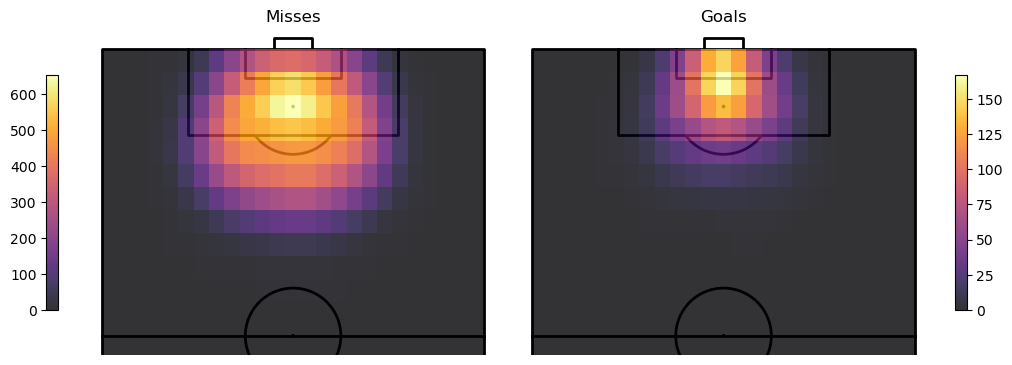

In [14]:
pitch = VerticalPitch(pitch_type="statsbomb", pitch_color='white', line_color='black', stripe=False, goal_type="box", half=True, label= False)
fig, axs = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)
pitch.draw(ax=axs[0])
pitch.draw(ax=axs[1])

shots_and_misses = shots[shots['shot_outcome'] != 'Goal']
shots_and_misses[["x_start", "y_start"]] = pd.DataFrame(shots_and_misses.location.tolist(), index=shots_and_misses.index)
bin_statistic_misses = pitch.bin_statistic(shots_and_misses.x_start, shots_and_misses.y_start, statistic='count', bins=(25, 25))
bin_statistic_misses['statistic'] = gaussian_filter(bin_statistic_misses['statistic'], 1)
pcm_misses = pitch.heatmap(bin_statistic_misses, ax=axs[0], cmap='inferno', edgecolors='None', alpha=0.8)
axs[0].set_title('Misses')


shots_and_goals = shots[shots["shot_outcome"] == "Goal"].reset_index(drop=True)
shots_and_goals[["x_start", "y_start"]] = pd.DataFrame(shots_and_goals.location.tolist(), index=shots_and_goals.index)
bin_statistic_goals = pitch.bin_statistic(shots_and_goals.x_start, shots_and_goals.y_start, statistic='count', bins=(25, 25))
bin_statistic_goals['statistic'] = gaussian_filter(bin_statistic_goals['statistic'], 1)
pcm_goals = pitch.heatmap(bin_statistic_goals, ax=axs[1], cmap='inferno', edgecolors='None', alpha=0.8)
axs[1].set_title('Goals')


fig.colorbar(pcm_misses, ax=axs[0], location='left', shrink=0.6)
fig.colorbar(pcm_goals, ax=axs[1], location='right', shrink=0.6)

plt.show()

# 5.2 Density of distance and angle<a id="denseplot"></a>

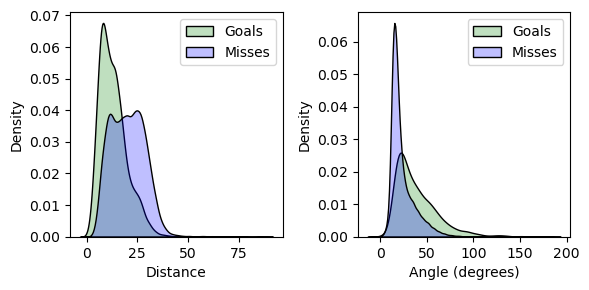

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(6, 3))

# Density plot for Distance
sns.kdeplot(shots_and_goals['shot_distance'], ax=axs[0], shade=True, color="green", edgecolor="black", label="Goals")
sns.kdeplot(shots_and_misses['shot_distance'], ax=axs[0], shade=True, color="blue", edgecolor="black", label="Misses")
axs[0].set_xlabel('Distance')
axs[0].legend()

# Density plot for Angle
sns.kdeplot(shots_and_goals['shot_angle'], ax=axs[1], shade=True, color="green", edgecolor="black", label="Goals")
sns.kdeplot(shots_and_misses['shot_angle'], ax=axs[1], shade=True, color="blue", edgecolor="black", label="Misses")
axs[1].set_xlabel('Angle (degrees)')
axs[1].legend()

plt.tight_layout()
plt.show()

# 5.3 Goal proportion headers and foot<a id="proportion"></a>

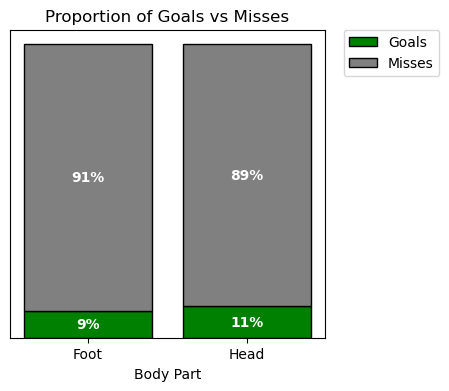

In [16]:
foot_shots_df = shots[(shots["shot_body_part"] == "Left Foot") | (shots["shot_body_part"] == "Right Foot")]
head_other_shots_df = shots[(shots["shot_body_part"] == "Head")]

foot_shots_count = len(foot_shots_df)
head_other_shots_count = len(head_other_shots_df)

foot_goals_count = foot_shots_df['Goal'].sum()
head_other_goals_count = head_other_shots_df['Goal'].sum()

foot_goal_proportion = foot_goals_count / foot_shots_count
head_other_goal_proportion = head_other_goals_count / head_other_shots_count
foot_shot_proportion = 1 - foot_goal_proportion
head_other_shot_proportion = 1 - head_other_goal_proportion

body_parts = ["Foot", "Head"]
goal_proportions = [foot_goal_proportion, head_other_goal_proportion]
shot_proportions = [foot_shot_proportion, head_other_shot_proportion]

plt.figure(figsize=(6, 4))

bars_goals = plt.bar(body_parts, goal_proportions, label='Goals', color='green', edgecolor="black")
bars_attempts = plt.bar(body_parts, shot_proportions, bottom=goal_proportions, label='Attempts', color='grey', edgecolor="black")

plt.xlabel("Body Part", fontsize=10)
plt.title("Proportion of Goals vs Misses", fontsize=12)
plt.grid(False)
plt.yticks([])

for bar_goal in bars_goals:
    x = bar_goal.get_x() + bar_goal.get_width() / 2
    y = bar_goal.get_y() + bar_goal.get_height() / 2
    goal_prop = goal_proportions[bars_goals.index(bar_goal)]
    plt.text(x, y, f"{goal_prop*100:.0f}%", ha='center', va='center', color='white', fontweight='bold')

for bar_attempt in bars_attempts:
    x = bar_attempt.get_x() + bar_attempt.get_width() / 2
    y = bar_attempt.get_y() + bar_attempt.get_height() / 2
    shot_prop = shot_proportions[bars_attempts.index(bar_attempt)]
    plt.text(x, y, f"{shot_prop*100:.0f}%", ha='center', va='center', color='white', fontweight='bold')

legend_label = [
    'Goals',
    'Misses'
]
plt.subplots_adjust(right=0.65)

plt.legend(labels=legend_label, loc='upper right', bbox_to_anchor=(1.385, 1.022), frameon=True)
plt.show()


# 5.4 Violin plot of distance and angle for body part<a id="violin"></a>

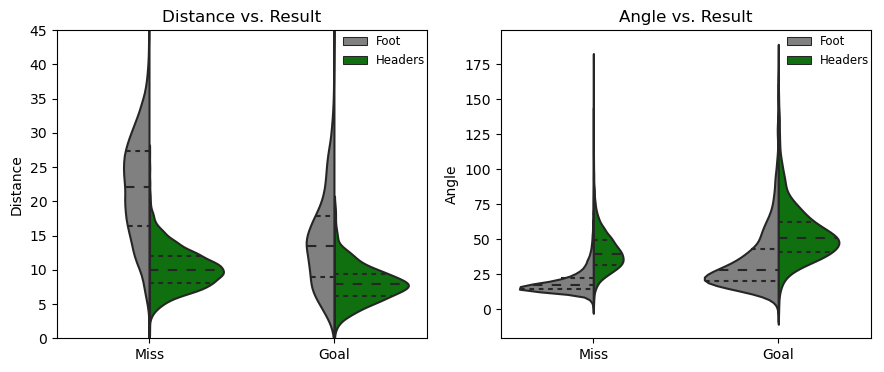

In [17]:
shots_body_part = shots.copy()
shots_body_part['shot_body_part'] = shots_body_part['shot_body_part'].replace({'Left Foot': 'Foot', 'Right Foot': 'Foot', 'Head': 'Headers'})
shots_body_part['Goal'] = shots_body_part['Goal'].replace({False: 'Miss', True: 'Goal'})

colors = {'Foot': 'grey', 'Headers': 'green'}
fig, axes = plt.subplots(1, 2, figsize=(10.5, 4))

shot_distance = sns.violinplot(x="Goal", y="shot_distance", hue='shot_body_part',
                    data=shots_body_part[shots_body_part['shot_body_part'].isin(['Foot', 'Headers'])], inner="quart", split=True, ax=axes[0], palette=colors)
shot_distance.set(xlabel="",
                  ylabel="Distance",
                  title="Distance vs. Result", ylim=(0, 45))


shot_angle = sns.violinplot(x="Goal", y="shot_angle", hue='shot_body_part',
                    data=shots_body_part[shots_body_part['shot_body_part'].isin(['Foot', 'Headers'])], inner="quart", split=True, ax=axes[1], palette=colors)
shot_angle.set(xlabel="",
                  ylabel="Angle",
                  title="Angle vs. Result")

shot_angle.title.set_size(12)
shot_distance.title.set_size(12)
axes[0].legend(loc='upper right', bbox_to_anchor=(1.025, 1.019), fontsize=8.5, frameon= False)
axes[1].legend(loc='upper right', bbox_to_anchor=(1.025, 1.019), fontsize=8.5, frameon= False)

plt.show()

# 5.5 Goal rate for strong foot and height above 185cm<a id="goal_rate"></a>

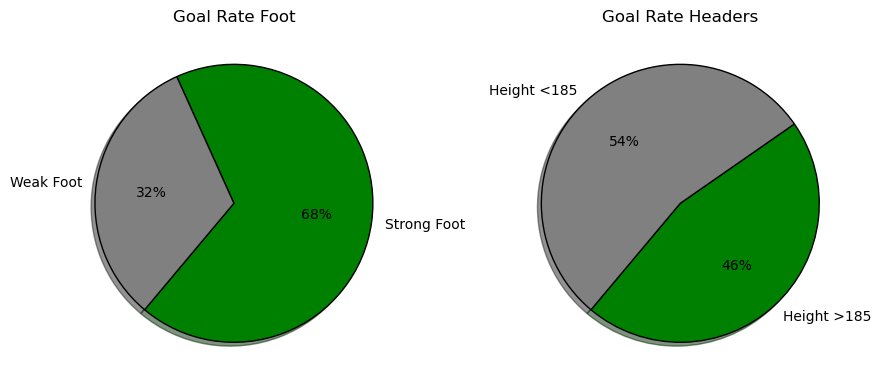

In [18]:
plt.figure(figsize=(9, 9)) 
goals_strong_foot = foot_shots_df[(foot_shots_df['Goal'] == True) & (foot_shots_df['is_strong_foot/big_height'] == True)].shape[0]
goals_non_strong_foot = foot_shots_df[(foot_shots_df['Goal'] == True) & (foot_shots_df['is_strong_foot/big_height'] == False)].shape[0]

labels_foot = ['Strong Foot', 'Weak Foot']
sizes_foot = [goals_strong_foot, goals_non_strong_foot]
colors_foot = ['green', 'grey']

plt.subplot(1, 2, 1)  
plt.pie(sizes_foot, labels=labels_foot, autopct='%1.0f%%', startangle=230, colors=colors_foot, wedgeprops={'edgecolor': 'black'}, shadow=True)
plt.title('Goal Rate Foot', fontsize=12)

goals_strong_foot = head_other_shots_df[(head_other_shots_df['Goal'] == True) & (head_other_shots_df['is_strong_foot/big_height'] == True)].shape[0]
goals_non_strong_foot = head_other_shots_df[(head_other_shots_df['Goal'] == True) & (head_other_shots_df['is_strong_foot/big_height'] == False)].shape[0]

labels_header = ['Height >185', 'Height <185']
sizes_header = [goals_strong_foot, goals_non_strong_foot]
colors_header = ['green', 'grey']

plt.subplot(1, 2, 2)  
plt.pie(sizes_header, labels=labels_header, autopct='%1.0f%%', startangle=230, colors=colors_header, wedgeprops={'edgecolor': 'black'}, shadow=True)
plt.title('Goal Rate Headers', fontsize=12)

plt.tight_layout()

plt.show()

Since we have a feature now that indicates whether kicked shots were taken with the strong we can replace "Left Foot" and "Right Foot" with "foot" in our shot_body_part column

In [19]:
shots['shot_body_part'] = shots['shot_body_part'].replace({'Right Foot': 'Foot', 'Left Foot': 'Foot'})

# 5.6 Market Value vs goals<a id="market_value"></a>

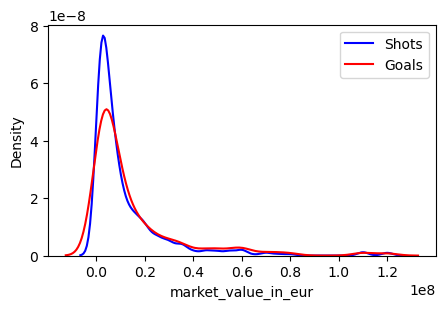

In [20]:
plt.figure(figsize=(5, 3))  

sns.kdeplot(shots['market_value_in_eur'], shade=False, color="blue", label="Shots")
sns.kdeplot(shots_and_goals["market_value_in_eur"], shade=False, color="red", label="Goals")
plt.ylabel('Density')
plt.legend()
plt.show()

# 5.7 Temporal patterns of goals<a id="temporal_patterns"></a>

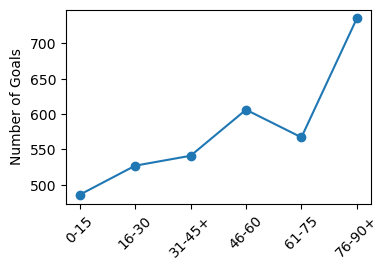

interval
0-15      486
16-30     527
31-45+    541
46-60     606
61-75     567
76-90+    735
dtype: int64

In [21]:
def categorize_interval(row):
    if row['period'] == 1:
        if row['minute'] <= 15:
            return '0-15'
        elif row['minute'] <= 30:
            return '16-30'
        else:
            return '31-45+'
    elif row['period'] == 2:
        if row['minute'] <= 60:
            return '46-60'
        elif row['minute'] <= 75:
            return '61-75'
        else:
            return '76-90+'
    else:
        return None

shots_and_goals['interval'] = shots_and_goals.apply(categorize_interval, axis=1)

goals_per_interval = shots_and_goals.groupby('interval').size()

plt.figure(figsize=(4, 3))
goals_per_interval.plot(kind='line', marker='o')
#plt.title('Number of Goals per Interval')
#plt.xlabel('Interval')
plt.ylabel('Number of Goals')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.xlabel('')  
plt.grid(False)
plt.show()
goals_per_interval

Because goals tend to follow a linear pattern we create the feature "interval"

In [22]:
shots['interval'] = shots.apply(categorize_interval, axis=1)

# 5.8 Shot ratio under different number of opponents in triangle<a id="opponent_in_triangle"></a>

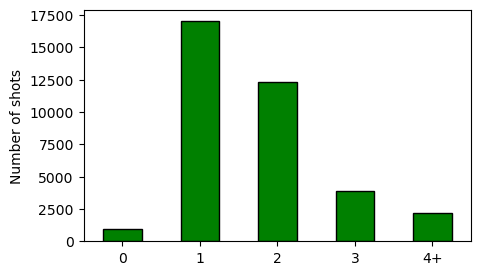

In [23]:
value_counts = shots['opponents_in_triangle'].value_counts().sort_index()

value_counts_aggregated = value_counts.copy()
value_counts_aggregated[4] = value_counts_aggregated[4:].sum()  # Sum counts for 4 and above
value_counts_aggregated = value_counts_aggregated[:5]

value_counts_aggregated.index = list(value_counts_aggregated.index[:-1]) + ['4+']

plt.figure(figsize=(5, 3))
value_counts_aggregated.plot(kind='bar', color='green', edgecolor='black')
#plt.xlabel('Number of Opponents in Triangle')
plt.ylabel('Number of shots')
plt.xticks(rotation=0)
plt.grid(False)
plt.show()

# 5.9 Shot ratio under different levels of opponents in pressure radius<a id="opponent_in_pressure_radius"></a>

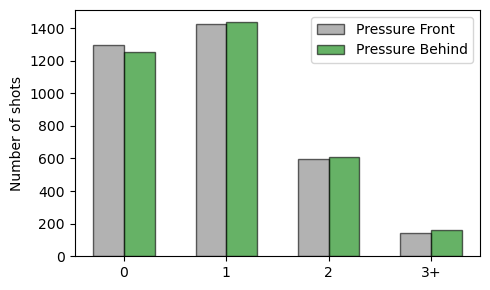

In [24]:
#aggregating the counts
pressure_front_counts = shots_and_goals['pressure_front'].value_counts().sort_index()
pressure_front_counts[3] = pressure_front_counts[3:].sum() 
pressure_front_counts = pressure_front_counts[:4]
pressure_front_counts.index = list(pressure_front_counts.index[:-1]) + ['3+']

#aggregating the counts
pressure_behind_counts = shots_and_goals['pressure_behind'].value_counts().sort_index()
pressure_behind_counts[3] = pressure_behind_counts[3:].sum() 
pressure_behind_counts = pressure_behind_counts[:4]
pressure_behind_counts.index = list(pressure_behind_counts.index[:-1]) + ['3+']

plt.figure(figsize=(5, 3))
bar_width = 0.30
index = range(len(pressure_front_counts))

plt.bar(index, pressure_front_counts, bar_width, label='Pressure Front', color='grey', alpha=0.6, edgecolor='black')
plt.bar([i + bar_width for i in index], pressure_behind_counts, bar_width, label='Pressure Behind', color='green', alpha=0.6, edgecolor='black')

#plt.xlabel('Pressure Level')
plt.ylabel('Number of shots')
plt.xticks([i + bar_width / 2 for i in index], pressure_front_counts.index)
plt.legend()
plt.tight_layout()
plt.show()

# 5.10 Count of different play patterns<a id="count_play_patterns"></a>

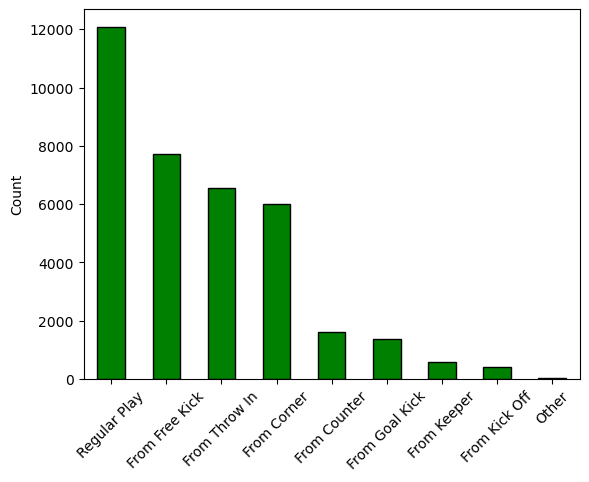

In [25]:
play_pattern_counts = shots['play_pattern'].value_counts()
play_pattern_counts.plot(kind='bar', color='green', edgecolor='black')
plt.xlabel('')
plt.ylabel('Count')
plt.grid(False)
plt.xticks(rotation=45)
plt.show()

# <strong>6 Modelling<a id="modelling"></a><strong>

Basic information about all the models we will create:

- Train test split of 70% and 30%
- Goals are stratified in training and testing data
- Continious numeric features are scaled with min-max scalling
- 10 fold cross validation is used for evaluation
- Hyperparamter tuning for models
- Metric for model evaluation is Log-Loss
- Custom class weights for the models to deal with the class imbalance!

The entire preprocessing and modelling will be done inside a pipeline!

# 6.1 Data splitting<a id="splitting"></a>

In [26]:
shots_features = shots[[
    'shot_distance', 'shot_angle', 'opponents_in_triangle', 'pressure_front', 'pressure_behind', 'position',
    'market_value_in_eur', 'shot_body_part', 'play_pattern', 'interval',
    'vertical_distance_to_gk', 'is_past_goalkeeper', 'is_strong_foot/big_height', 'Goal'
]]

X = shots_features.drop(['Goal'], axis=1)
Y = shots_features['Goal']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=2023, stratify=Y)

In [27]:
# final

In [28]:
shots_features = shots[[
    'shot_distance', 'shot_angle', 'opponents_in_triangle', 'pressure_front', 'pressure_behind', 'position',
    'market_value_in_eur', 'shot_body_part', 'play_pattern',
    'vertical_distance_to_gk', 'is_strong_foot/big_height', 'Goal'
]]

X = shots_features.drop(['Goal'], axis=1)
Y = shots_features['Goal']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=2023, stratify=Y)

# 6.3 Preprocessing pipeline<a id="pipeline"></a>

In [29]:
# Scaling with standard scaling and imputing with mean
numeric_pipeline = Pipeline([ ('Imputing', SimpleImputer(strategy='mean')), ('Scaling', StandardScaler())
])
# One hot ecnoding and imputing with the most frequent vale
categorical_pipeline = Pipeline([ ('Imputing', SimpleImputer(strategy='most_frequent')),('Encoding', OneHotEncoder())])

# This converts boolean values to integers (0 and 1) and then also imputes the values with the most frequent value of the column
boolean_pipeline = Pipeline([('Bool_to_int', FunctionTransformer(lambda x: x.astype(int))), ('Imputing', SimpleImputer(strategy='most_frequent'))])
numeric_columns = X.select_dtypes(include=[np.number]).columns
categorical_columns = X.select_dtypes(exclude=[np.number, 'boolean']).columns
boolean_columns = X.select_dtypes(include=['boolean']).columns

final_preprocessing_pipeline = ColumnTransformer([
    ('numeric', numeric_pipeline, numeric_columns),
    ('categorical', categorical_pipeline, categorical_columns),
    ('boolean', boolean_pipeline, boolean_columns) 
])

final_preprocessing_pipeline.fit(X_train)
encoded_feature_names = final_preprocessing_pipeline.named_transformers_['categorical']['Encoding'].get_feature_names_out(categorical_columns) # get encoded categorical feature names
final_feature_names = np.concatenate([numeric_columns, encoded_feature_names, boolean_columns]) # concatenate numeric, cateogrical and boolean columns
final_preprocessing_pipeline

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('Imputing', SimpleImputer()),
                                                 ('Scaling',
                                                  StandardScaler())]),
                                 Index(['shot_distance', 'shot_angle', 'opponents_in_triangle',
       'pressure_front', 'pressure_behind', 'market_value_in_eur',
       'vertical_distance_to_gk'],
      dtype='object')),
                                ('categorical',
                                 Pipeline(steps=[('Imputing',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('Encoding',
                                                  OneHotEncoder())]),
                                 Index(['position', 'shot_body_part', 'play_pattern'], dtype='object')),
                                ('boolean',
                                 Pipeline(steps=[('Bool_to_int',
                                                  FunctionTransformer(func=<function <lambda> at 0x10b021a80>)),
                                                 ('Imputing',
                                                  SimpleImputer(strategy='most_frequent'))]),
                                 Index(['is_strong_foot/big_height'], dtype='object'))])

# 6.4 Final models<a id="models"></a>

## <i>6.4.1 Logistic Regression<a id="logistic_regression"></a><i>    

In [30]:
pipeline_logistic_regression = Pipeline([
    ('preprocessor', final_preprocessing_pipeline), ('logistic_regression', LogisticRegression(max_iter=10000, random_state=2023))
])

hyperparameter_logistic_regression = {
    'logistic_regression__C': [0.001, 0.01, 0.05, 0.1, 0.5, 1, 5, 10], 
    'logistic_regression__penalty': ['l1', 'l2', None], 
}

logistic_regression = RandomizedSearchCV(
    estimator=pipeline_logistic_regression,  # Use the pipeline as the estimator
    param_distributions=hyperparameter_logistic_regression,
    cv=10,
    scoring='neg_log_loss',
    n_jobs=-1,
    return_train_score=True,
    random_state=2023
)

# Fit the model to the training data
logistic_regression.fit(X_train, Y_train)

# Print the model's performance on training and test sets
print('Final score on training-set is: ', round(logistic_regression.score(X_train, Y_train), 3))
print('Final score on test-set is: ', round(logistic_regression.score(X_test, Y_test), 3))

# Print the best hyperparameters found
print('\nBest params:\n', logistic_regression.best_params_)

/Users/sinahaghgoo/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/sinahaghgoo/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/sinahaghgoo/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/sinahaghgoo/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/sinahaghgoo/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/sinahaghgoo/anaconda3/lib/python3.11/s

Final score on training-set is:  -0.258
Final score on test-set is:  -0.26

Best params:
 {'logistic_regression__penalty': 'l2', 'logistic_regression__C': 0.1}


## <i>6.4.2 Random Forest<a id="random_forest"></a><i>        

In [31]:
pipeline_random_forest = Pipeline([
    ('preprocessor', final_preprocessing_pipeline),
    ('random_forest', RandomForestClassifier(random_state=2023))
])

hyperparameters_random_forest = {
        
   #'random_forest__n_estimators': [10, 15, 20, 25, 30 , 35, 40, 50],
   #'random_forest__max_depth': [3, 4, 5, 6, 7, 8, 9, 10], 
  #'random_forest__min_samples_split': [1, 2, 3, 4, 5, 6, 7, 10, 15],    

  #'random_forest__n_estimators': [20, 30, 50, 80, 100, 120, 150, 200],   
  #'random_forest__max_depth': [2, 3, 4, 5, 6, 7, 8],
  #'random_forest__min_samples_split': [1, 2, 3, 4, 5, 6, 7, 10, 15],     
    
  'random_forest__n_estimators': [30, 50, 80, 100, 120, 150, 200, 250, 300],   
  'random_forest__max_depth': [2, 3, 4, 5, 6, 7],
  'random_forest__min_samples_split': [1, 2, 3, 4, 5, 6, 7, 10, 15],        

}

random_forest_model = RandomizedSearchCV(
    estimator=pipeline_random_forest,
    param_distributions=hyperparameters_random_forest,
    cv=10,
    scoring='neg_log_loss',
    n_jobs=-1,
    return_train_score=True,
    random_state=2023
)

random_forest_model.fit(X_train, Y_train)

print('Final score on training-set is: ', round(random_forest_model.score(X_train, Y_train), 3))
print('Final score on test-set is: ', round(random_forest_model.score(X_test, Y_test), 3))
print('\nBest params:\n', random_forest_model.best_params_)

Final score on training-set is:  -0.246
Final score on test-set is:  -0.261

Best params:
 {'random_forest__n_estimators': 100, 'random_forest__min_samples_split': 4, 'random_forest__max_depth': 7}


## <i>6.4.3 XG-Boost<a id="xgboost"></a><i>            

In [32]:
pipeline_xgboost = Pipeline([
    ('preprocessor', final_preprocessing_pipeline),  
    ('xgboost', XGBClassifier(random_state=2023))
])

hyperparameters_xgboost = {
    
  'xgboost__learning_rate': [0.001, 0.01, 0.1, 0.2, 0.5, 1],
  'xgboost__max_depth'        : [3, 4, 6, 10, 15],  

}

xgboost_model = RandomizedSearchCV(
    estimator=pipeline_xgboost,
    param_distributions=hyperparameters_xgboost,
    cv=10,
    scoring='neg_log_loss',
    n_jobs=-1,
    random_state=2023,
    return_train_score=True
)

xgboost_model.fit(X_train, Y_train)

print('Final score on training-set is: ', round(xgboost_model.score(X_train, Y_train), 3))
print('Final score on test-set is: ', round(xgboost_model.score(X_test, Y_test),3))
print('\nBest params:\n', xgboost_model.best_params_)

Final score on training-set is:  -0.237
Final score on test-set is:  -0.257

Best params:
 {'xgboost__max_depth': 4, 'xgboost__learning_rate': 0.1}


# 6.5 Model comparision<a id="Model_comparision"></a> 

## 6.5.1 Log Loss<a id="log_loss"></a> 

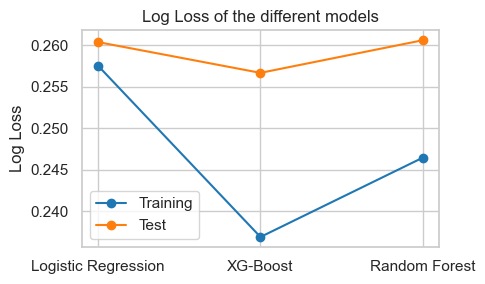

In [33]:
best_params_lr = logistic_regression.best_params_

final_lr_model = Pipeline([
    ('preprocessor', final_preprocessing_pipeline),
    ('logistic_regression', LogisticRegression(
        C=best_params_lr['logistic_regression__C'],  
        max_iter=10000,
        random_state=2023
    ))
])
final_lr_model.fit(X_train, Y_train)


best_params_rf = random_forest_model.best_params_

final_rf_model = Pipeline([
    ('preprocessor', final_preprocessing_pipeline),
    ('random_forest', RandomForestClassifier(
        n_estimators=best_params_rf['random_forest__n_estimators'],
        max_depth=best_params_rf['random_forest__max_depth'],  
        min_samples_split=best_params_rf['random_forest__min_samples_split'], 
        random_state=2023
    ))
])
final_rf_model.fit(X_train, Y_train)



best_params_xgb = xgboost_model.best_params_

final_xgb_model = Pipeline([
    ('preprocessor', final_preprocessing_pipeline),
    ('xgboost', XGBClassifier(
        learning_rate=best_params_xgb['xgboost__learning_rate'],  
        max_depth=best_params_xgb['xgboost__max_depth'],  
        random_state=2023
    ))
])





final_xgb_model.fit(X_train, Y_train)

lr_probs_train = final_lr_model.predict_proba(X_train)
lr_probs_test = final_lr_model.predict_proba(X_test)

rf_probs_train = final_rf_model.predict_proba(X_train)
rf_probs_test = final_rf_model.predict_proba(X_test)

xgb_probs_train = final_xgb_model.predict_proba(X_train)
xgb_probs_test = final_xgb_model.predict_proba(X_test)


train_log_loss_lr = log_loss(Y_train, lr_probs_train)
test_log_loss_lr = log_loss(Y_test, lr_probs_test)

train_log_loss_rf = log_loss(Y_train, rf_probs_train)
test_log_loss_rf = log_loss(Y_test, rf_probs_test)

train_log_loss_xgb = log_loss(Y_train, xgb_probs_train)
test_log_loss_xgb = log_loss(Y_test, xgb_probs_test)


data = {
    'Logistic Regression': {
        'Log Loss': {'Train': train_log_loss_lr, 'Test': test_log_loss_lr}
    },
        'XG-Boost': {
        'Log Loss': {'Train': train_log_loss_xgb, 'Test': test_log_loss_xgb}
    },
    
    'Random Forest': {
        'Log Loss': {'Train': train_log_loss_rf, 'Test': test_log_loss_rf}
    }

}


sns.set(style='whitegrid')
colors = ['#1f77b4', '#ff7f0e']
plt.figure(figsize=(5, 3))

models = list(data.keys())
train_data = [data[model]['Log Loss']['Train'] for model in models]
test_data = [data[model]['Log Loss']['Test'] for model in models]

plt.plot(models, train_data, label="Training", marker='o', color=colors[0])
plt.plot(models, test_data, label="Test", marker='o', color=colors[1])
plt.ylabel('Log Loss')
plt.title("Log Loss of the different models")
plt.legend()

plt.tight_layout()
plt.show()

## 6.5.2 ROC-AUC Curve comparision<a id="roc_auc"></a> 

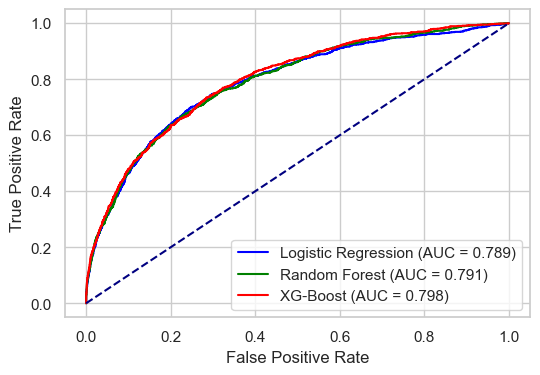

In [34]:
# Calculate for Logistic Regression
fpr_lr, tpr_lr, _ = roc_curve(Y_test, lr_probs_test[:, 1])
auc_lr = roc_auc_score(Y_test, lr_probs_test[:, 1])

# Calculate for Random Forest
fpr_rf, tpr_rf, _ = roc_curve(Y_test, rf_probs_test[:, 1])
auc_rf = roc_auc_score(Y_test, rf_probs_test[:, 1])

# Calculate for XG-Boost
fpr_xgb, tpr_xgb, _ = roc_curve(Y_test, xgb_probs_test[:, 1])
auc_xgb = roc_auc_score(Y_test, xgb_probs_test[:, 1])

plt.figure(figsize=(6, 4))

# Plotting the ROC Curve for Logistic Regression
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.3f})', color='blue')

# Plotting the ROC Curve for Random Forest
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.3f})', color='green')

# Plotting the ROC Curve for XG-Boost
plt.plot(fpr_xgb, tpr_xgb, label=f'XG-Boost (AUC = {auc_xgb:.3f})', color='red')

# Plotting the no-skill line
plt.plot([0, 1], [0, 1], linestyle='--', color='navy')

# Adding labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

### Based on the evaluation we take the XGBOOST as trained model for our performance analysis!

# <strong>7 Feature Importance Analysis<a id="importance"></a><strong>

# 7.1 Logistic Regression<a id="logistic_regression_FI"></a>     

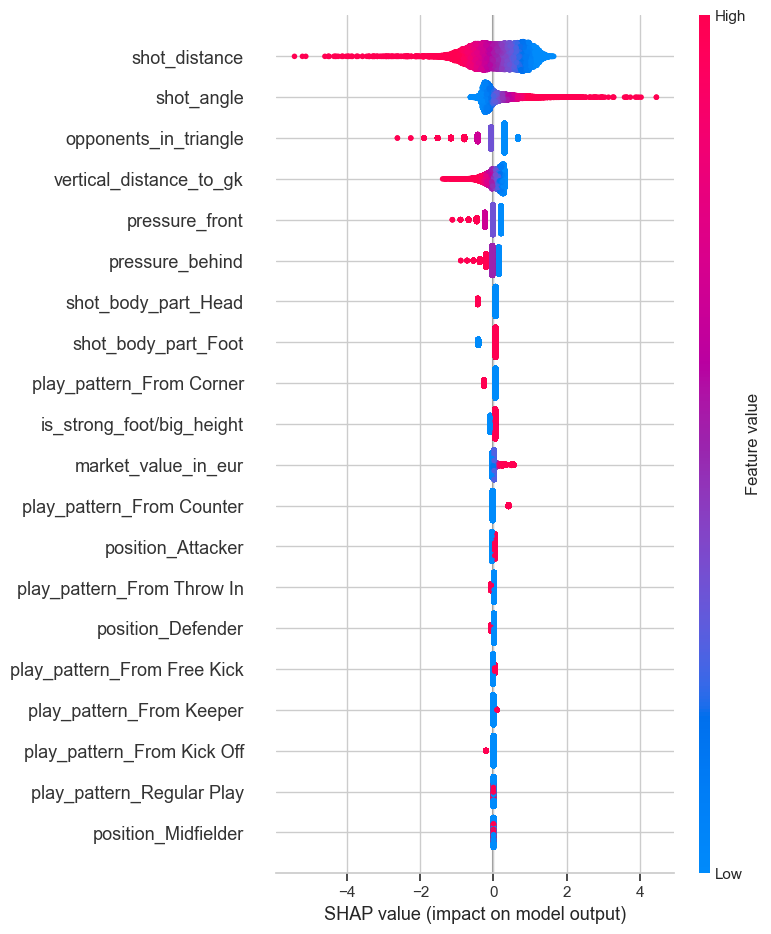

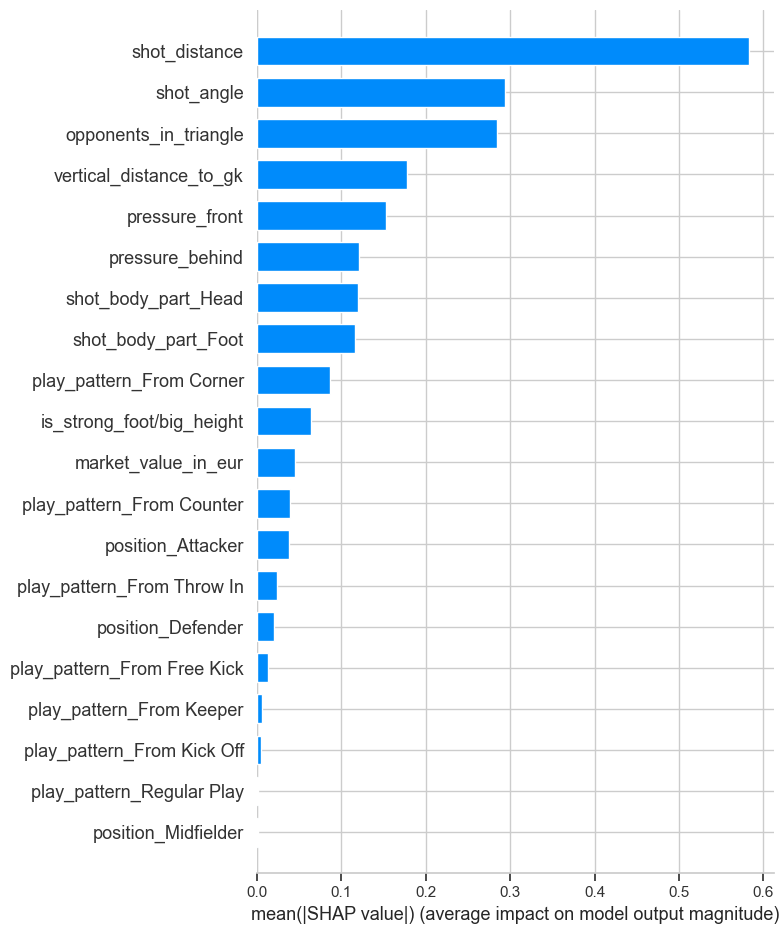

In [35]:
best_model = logistic_regression.best_estimator_
X_train_transformed = best_model.named_steps['preprocessor'].transform(X_train)
explainer = shap.Explainer(best_model.named_steps['logistic_regression'], X_train_transformed)
shap_values = explainer(X_train_transformed)
shap.summary_plot(shap_values, X_train_transformed, feature_names=final_feature_names)
shap.summary_plot(shap_values, X_train_transformed, feature_names=final_feature_names, plot_type="bar")

# 7.2 Random Forest<a id="random_forest_FI"></a>         

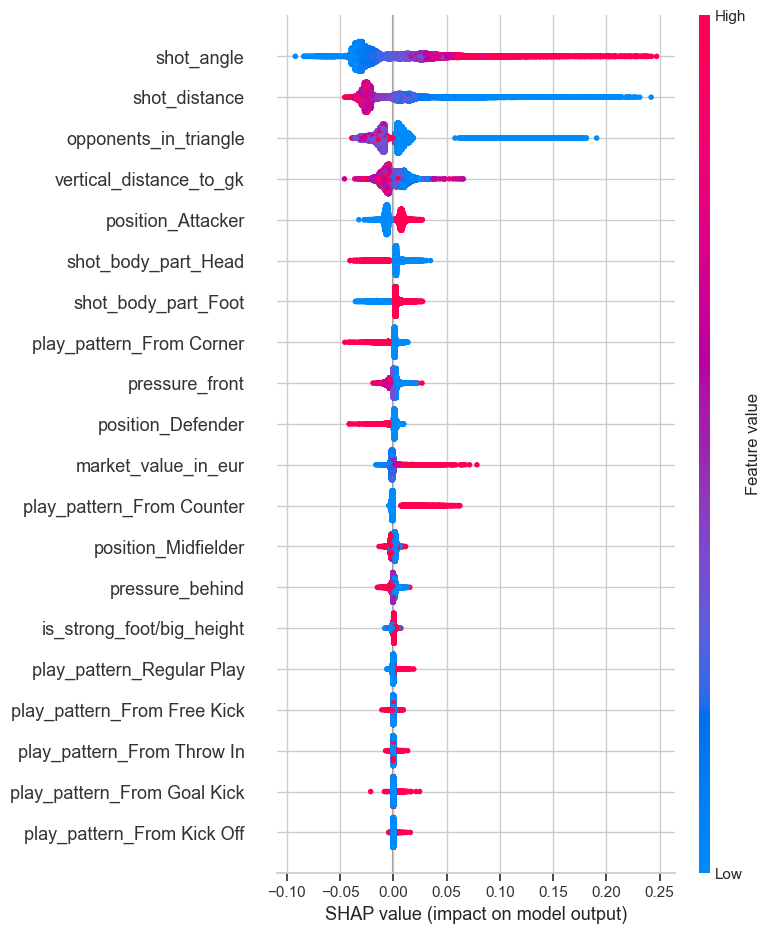

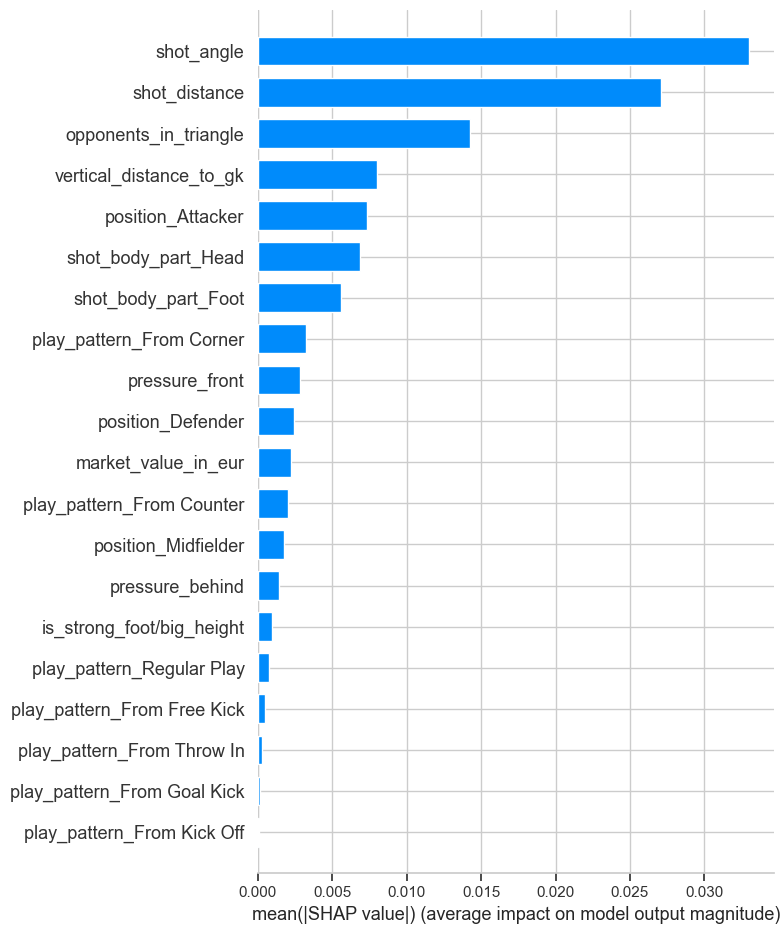

In [36]:
best_model = random_forest_model.best_estimator_

X_test_transformed = best_model.named_steps['preprocessor'].transform(X_train)

explainer = shap.TreeExplainer(best_model.named_steps['random_forest'])

shap_values = explainer.shap_values(X_test_transformed)
shap_values_positive_class = shap_values[1]  

shap.summary_plot(shap_values_positive_class, X_test_transformed, feature_names=final_feature_names)

shap.summary_plot(shap_values_positive_class, X_test_transformed, feature_names=final_feature_names, plot_type="bar")

# 7.3 XGBOOST<a id="xgboost_FI"></a>             

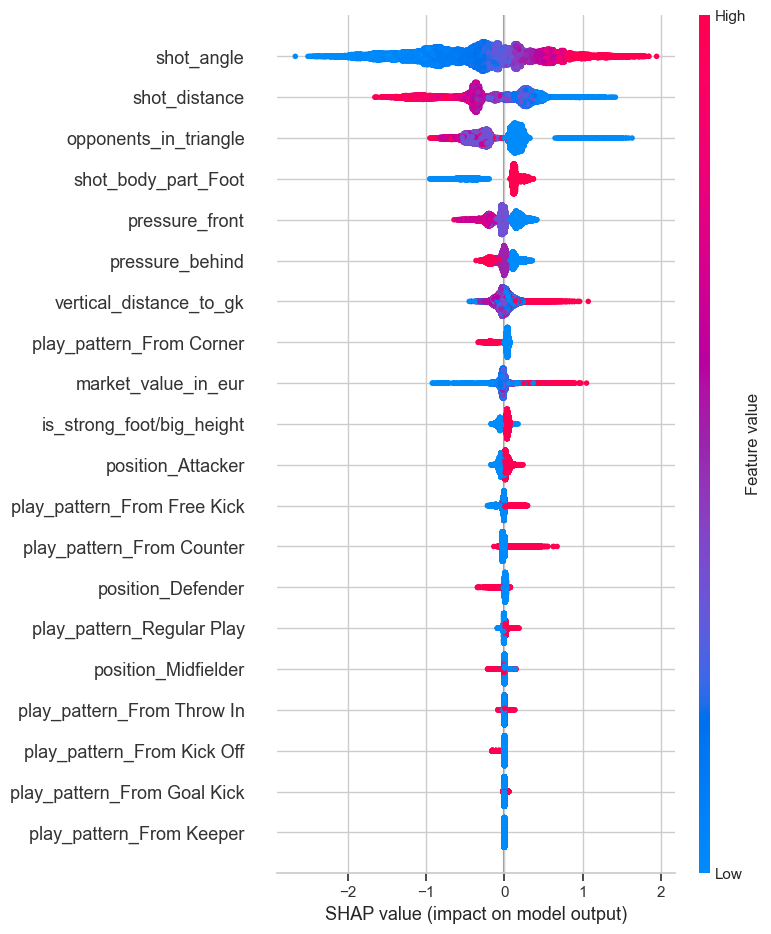

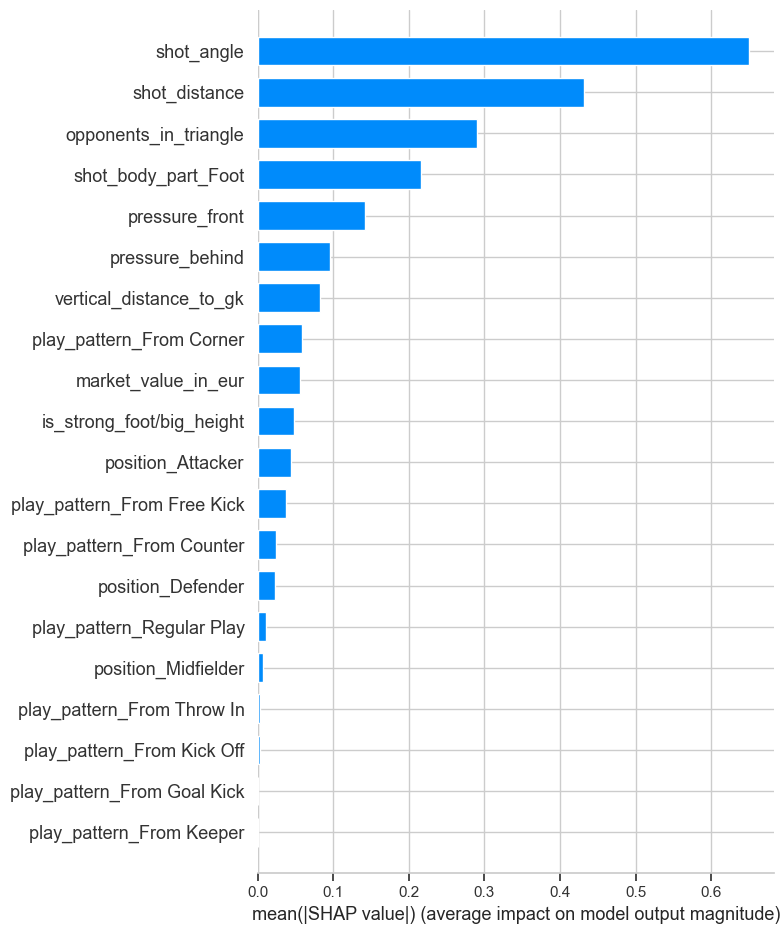

In [37]:
best_model = xgboost_model.best_estimator_


X_test_transformed = best_model.named_steps['preprocessor'].transform(X_train)


explainer = shap.TreeExplainer(best_model.named_steps['xgboost'])

shap_values = explainer(X_test_transformed)

shap.summary_plot(shap_values, X_test_transformed, feature_names=final_feature_names)
shap.summary_plot(shap_values, X_test_transformed, feature_names=final_feature_names, plot_type="bar")

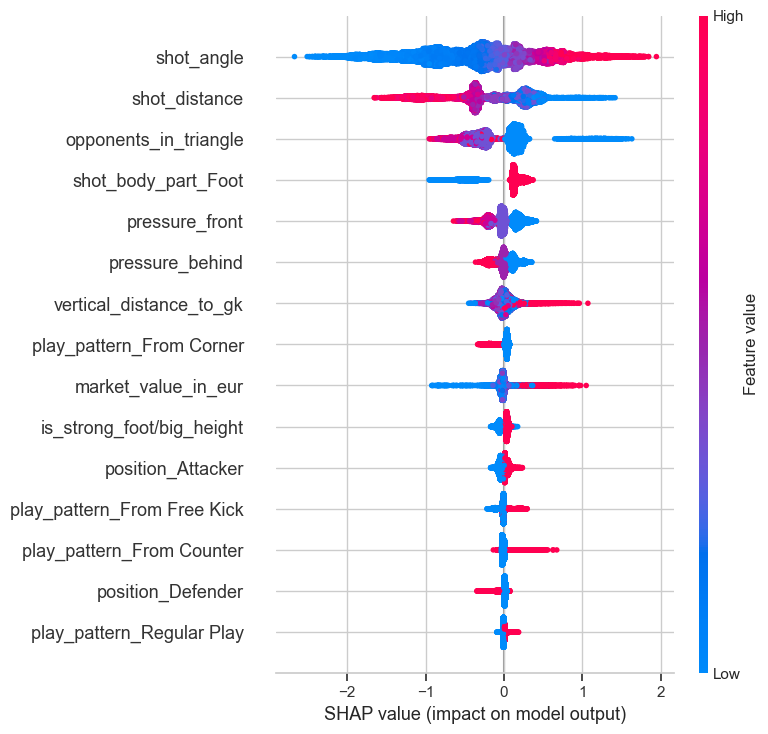

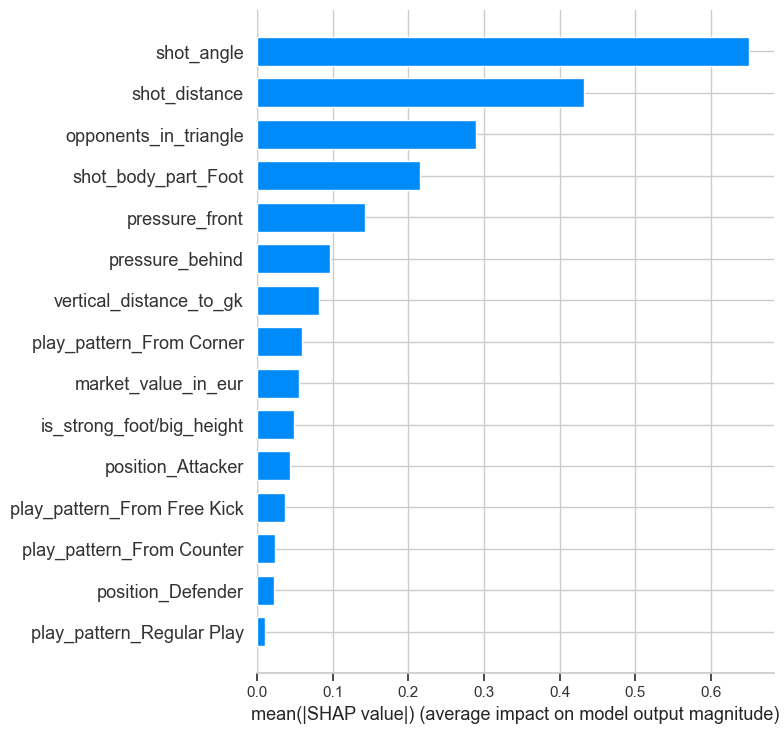

In [38]:
abs_shap_values = np.abs(shap_values.values)

# Calculate the mean absolute SHAP value for each feature
mean_abs_shap_values = np.mean(abs_shap_values, axis=0)

# Sort features based on mean absolute SHAP values and select the top 15
top_features_idx = np.argsort(mean_abs_shap_values)[::-1][:15]

# Select the corresponding feature names
top_feature_names = [final_feature_names[i] for i in top_features_idx]

# Filter SHAP values and transformed data to include only the top features
top_shap_values = shap_values[:, top_features_idx]
X_test_transformed_top = X_test_transformed[:, top_features_idx]

# Plot summary plot for the top features
shap.summary_plot(top_shap_values, X_test_transformed_top, feature_names=top_feature_names)
shap.summary_plot(top_shap_values, X_test_transformed_top, feature_names=top_feature_names, plot_type="bar")

# <strong>8 Player performance analysis<a id="modelling1"></a><strong>    

We will now proceed with our player performance analysis. Concretely we will take our best performing model, which is the xgboost and use it on the World Cup 2022 data from statsbomb in order to asses the performance of the players who took part in this tournament.


Our analysis starts by extracting the players with the highest total expected Goals, throughout the entire tournament. Concretely we will compare the xG value of the top 10 players of the tournament with their actual goal contribution, in order to see which players overperformed and who underperformed. Additionally we will investigate if the players leading in goals scored and shots taken also rank among the top ten in expected goals (xG).

Following that, we extract the xG per 90 minutes and  goals per 90 minutes for each player and look at the biggest over- and underperformers of the tournament. The amount of minutes played for each player is available in World Cup 2022 dataset from Kaggle.com <a href="#ref7">[8]</a>. This dataset is based on data from https://fbref.com/de/.  

Lastly, we'll look at the market value updates that Transfermarkt published after the World Cup and investigate the market value updates for the players we analyzed in the previous steps. It is important to note that Transfermarkt did only publish market value increases after the World Cup and didn't downgrade any players. The full market value update was on the end of March but since a lot of club ways were played bettween the end of the World Cup and this time period, our results would have been skewed.

# 8.1 Preparing data<a id="loading_WC2"></a>             

## 8.1.1 Loading World Cup 2022 data<a id="loading_WC"></a>             

In [313]:
WC_2022_matches = sb.matches(competition_id=43, season_id=106) # world cup 2022
all_matches = pd.concat([WC_2022_matches], ignore_index=True) # combining data
all_matches = all_matches.sort_values(by=['match_date', 'kick_off'])

match_ids = []
for entry in all_matches['match_id']:
    match_ids.append(entry)
    
    
all_events = pd.DataFrame()

# Looping through each match_id
for match_id in match_ids:
    # Fetching events for this match_id using the API
    events = sb.events(match_id=match_id)

    # Converting events to a DataFrame (just to be sure that everything is in a df)
    events_df = pd.DataFrame(events)

    # Adding the match_id as a column to the events DataFrame
    events_df['match_id'] = match_id

    all_events = pd.concat([all_events, events_df], ignore_index=True)
all_events = all_events.merge(all_matches[['match_id', 'match_date']], on='match_id', how='left') # adding the match_date to events because it's relevant for later

# creating final dataframe for shots
shots = all_events[(all_events["type"] == "Shot") & (all_events['shot_type'] != 'Penalty') & (all_events['period'] != 5)].reset_index(drop=True) # selecting all shots that weren't a penalty
# List of features to keep for shots
features_to_keep_shots = ["match_id", "id", "player", "player_id", "period", "play_pattern", "position", "location", "shot_body_part", "shot_freeze_frame", "shot_outcome", "timestamp", "minute", "match_date", "shot_statsbomb_xg"]
shots = shots[features_to_keep_shots]
#shots = shots[shots['shot_body_part'] != "Other"]

## 8.1.2 Details about data<a id="details_WC"></a>             

In [314]:
all_matches['total_goals'] = all_matches['home_score'] + all_matches['away_score']
average_goals_per_match = (all_matches['home_score'] + all_matches['away_score']).sum() / len(all_matches)

unique_teams = pd.concat([all_matches['home_team'], all_matches['away_team']]).unique()
number_of_teams = len(unique_teams)

print(f"Total number of different teams: {number_of_teams}")
print(f"Total number of different players: {len(shots['player'].unique())}") 
print(f"Total number of matches: {all_matches.shape[0]}")
print(f"Total number of shots: {len(shots)}")
print(f"Total number of goals: {(all_matches['home_score'] + all_matches['away_score']).sum()}")
print(f"Average number of goals per match: {round(average_goals_per_match, 1)}")

Total number of different teams: 32
Total number of different players: 428
Total number of matches: 64
Total number of shots: 1430
Total number of goals: 172
Average number of goals per match: 2.7


## 8.1.3 Feature engineering with all features from trained model<a id="FE_train"></a>             

In [315]:
shots['shot_distance'] = shots['location'].apply(calculate_distance_to_goal)
shots['shot_angle'] = shots['location'].apply(calculate_angle) 
shots['vertical_distance_to_gk'] = shots.apply(lambda x: vertical_distance_gk_shot_location_and_past_gk(x, shots)[0], axis=1)
shots['opponents_in_triangle'] = shots.apply(lambda row: opponents_triangle(row, shots), axis=1) 
shots[['pressure_front', 'pressure_behind']] = shots.apply(lambda row: opponents_circle(row, shots), axis=1, result_type="expand")



# player mapping for Transfermarkt and Statsbomb player names
player_mapping = {}
for player_name_statsbomb in shots['player']:
    matching_player = find_matching_player(player_name_statsbomb, players_info)
    player_mapping[player_name_statsbomb] = matching_player
refined_player_mapping = refine_player_mapping(player_mapping)    

### 
#updating the player mapping dictionary manually with player mappings that were missed by our algorithm
updated_values = { # NOTE: The keys are always the names from Statsbombs data and the values are the names on Transfermarkt.com
    'Neymar da Silva Santos Junior': 'Neymar',
    'Breel-Donald Embolo': 'Breel Embolo',
    'João Félix Sequeira': 'João Félix',
    'Rafael Alexandre Conceição Leão': 'Rafael Leão',
    'Vinícius José Paixão de Oliveira Júnior': 'Vinicius Junior',
    'Rodrygo Silva de Goes': 'Rodrygo',
    'Richarlison de Andrade': 'Richarlison',
}

for key, value in updated_values.items():
    if key in refined_player_mapping and refined_player_mapping[key] is None:
        refined_player_mapping[key] = value
###        
        
# For nicer looking plots we also saved the names from Transfermarkt beside the full passport names from Statsbomb. Since we still need the statsbomb names for further merging we also keep those
shots['player_name_short'] = shots['player'].map(refined_player_mapping)





# strong foot and height
players_grouped = players_info.groupby('name').agg({'foot': 'first'}).reset_index()
shots['strong_foot'] = shots['player'].map(refined_player_mapping).map(players_grouped.set_index('name')['foot'])
players_grouped = players_info.groupby('name').agg({'height_in_cm': 'first'}).reset_index()
shots['height'] = shots['player'].map(refined_player_mapping).map(players_grouped.set_index('name')['height_in_cm'])
shots['is_strong_foot/big_height'] = shots.apply(evaluate_shot, axis=1)
players_grouped = players_info.groupby('name').agg({'date_of_birth': 'first'}).reset_index()
shots['birth'] = shots['player'].map(refined_player_mapping).map(players_grouped.set_index('name')['date_of_birth'])



#market value
###
players_values = pd.read_csv('player_valuations.csv', delimiter=',')

# we merge player values with player info to get the names of the players
players_values = players_values.merge(players_info[['player_id', 'name']], on='player_id', how='left') 

shots["match_date"] = pd.to_datetime(shots["match_date"])       
players_values["date"] = pd.to_datetime(players_values["date"])

market_values = []


for index, row in shots.iterrows():
    player_name = row['player']
    match_date = row['match_date']
    
    if player_name in refined_player_mapping:  
        player_name_mapped = refined_player_mapping[player_name]
    else:
        player_name_mapped = player_name
    
    filtered_df = players_values[players_values['name'] == player_name_mapped]
    
    if not filtered_df.empty:
        # Calculating the absolute date difference and find the closest date
        filtered_df['date_diff'] = abs(filtered_df['date'] - match_date)
        closest_row = filtered_df.loc[filtered_df['date_diff'].idxmin()]
        
        # Get the market value from the closest date
        market_value = closest_row['market_value_in_eur']
        market_values.append(market_value)
    else:
        market_values.append(None) 

shots['market_value_in_eur'] = market_values
###

shots['Goal'] = shots['shot_outcome'] == 'Goal'    

# position
shots = shots.apply(update_position, axis=1)
    
# applied data cleaning after EDA
shots['shot_body_part'] = shots['shot_body_part'].replace({'Right Foot': 'Foot', 'Left Foot': 'Foot'})


#final features we want to keep
shots_data = shots[[
    'shot_distance', 'shot_angle', 'opponents_in_triangle', 'pressure_front', 'pressure_behind',
    'market_value_in_eur', 'shot_body_part', 'play_pattern', 'position', 'vertical_distance_to_gk', 'is_strong_foot/big_height', 'Goal'
]]

## 8.1.4 Running xgboost model on new data<a id="xgboost_WC_"></a>             

Now we run the best model, which is the xgboost model together with its parameter on our new data. 

In [316]:
X = shots_data.drop(['Goal'], axis=1)
Y = shots_data['Goal']

final_xgb_model = Pipeline([
    ('preprocessor', final_preprocessing_pipeline),
    ('xgboost', XGBClassifier( 
        learning_rate=best_params_xgb['xgboost__learning_rate'],
        max_depth=best_params_xgb['xgboost__max_depth'],
        random_state=2023
    ))
])
final_xgb_model.fit(X, Y)
expected_goals_WC = final_xgb_model.predict_proba(X)

# 8.2 Correlation between statsbomb expected goals values and our models<a id="xgboost_WC_"></a>             

It is interresting to investigate the correlation between our expected goal values and the one that Statsbomb provides. We can see a comparably strong correlation of 76%.

In [317]:
xG_probabilities = expected_goals_WC[:, 1] # # selects the second column for all rows, which is the probability of a goal
shots['xG'] = xG_probabilities
correlation = shots['shot_statsbomb_xg'].corr(shots['xG'])

print(f"The correlation between 'shot_statsbomb_xg' and 'xG' is: {correlation}")

The correlation between 'shot_statsbomb_xg' and 'xG' is: 0.7594131451365707


# 8.3 Analysing player performance<a id="player_performance"></a>             

First we will extract the latest available market value for each player before the start of the tournament on 2022-11-20 . In order to be able to compare the market value change between the beginning of the tournament and the first updated market value after the World Cup, we will extract the first available market value after the end of the tournament, for each player who participated in the tournament. However, since Transfermarkt only released an market value update between 2022-12-17 and 2022-12-25, we only consider values from this update. NOTE: The market value update only consisted of market value upgrades and Transfermarkt didn't downgrade any players with this update. The next big update (which also included downgrades) was published at the end of March and this would have skewed our results because a lot of club games would have been considered.

In [318]:

players_values = pd.read_csv('player_valuations.csv', delimiter=',')
players_values = players_values.merge(players_info[['player_id', 'name']], on='player_id', how='left')
# Convert dates from string to datetime
shots["match_date"] = pd.to_datetime(shots["match_date"])
players_values["date"] = pd.to_datetime(players_values["date"])

# updated market values
players_values_dec_2022 = players_values[(players_values['date'] > '2022-12-17') & (players_values['date'] < '2022-12-25')]

#values before 2022-11-20
players_values_pre_20221120 = players_values[players_values['date'] < '2022-11-20']

market_values_2023 = [] 
closest_market_values = []

for index, row in shots.iterrows():
    player_name = row['player']
    match_date = row['match_date']
    
    player_name_mapped = refined_player_mapping.get(player_name, player_name)

    # Find closest market value before 2022-11-20
    filtered_df = players_values_pre_20221120[players_values_pre_20221120['name'] == player_name_mapped]
    if not filtered_df.empty:
        closest_value = filtered_df.sort_values(by='date', ascending=False).iloc[0]
        closest_market_values.append(closest_value['market_value_in_eur'])
    else:
        closest_market_values.append(None)
    
    # Determine the market value in 2023
    filtered_df = players_values_dec_2022[players_values_dec_2022['name'] == player_name_mapped]
    if not filtered_df.empty:
        first_row_after_2022 = filtered_df.sort_values(by='date', ascending=True).iloc[0]
        market_value_2023 = first_row_after_2022['market_value_in_eur']
        market_values_2023.append(market_value_2023)
    else:
        market_values_2023.append(None)

shots['market_value_in_eur'] = closest_market_values
shots['market_value_in_eur_2023'] = market_values_2023

We will now continue to calculate the aggregated xG for each player. It is important to note that we also considered penalties for our player performance analysis but with the fixed value of 0.78 (the reasoning for that explained in the thesis)

In [319]:
shots["birth"] = pd.to_datetime(shots["birth"])
aggregated_data = shots.groupby('player').agg({
    'xG': 'sum',  # Sum of xG for each player
    'market_value_in_eur': 'first',  # Assuming market value is constant
    'Goal': 'sum',  # Sum of goals for each player
    'market_value_in_eur_2023': 'first',  # Assuming market value in 2023 is constant
    'birth': 'first',  # Adding birth date for each player
    'player_name_short': 'first'  # short name from transfermarkt for nicer looking plots       
}).reset_index()


aggregated_data['shots'] = shots.groupby('player').size().values

aggregated_data = aggregated_data.sort_values(by='xG', ascending=False)
aggregated_data['market_value_change'] = aggregated_data['market_value_in_eur_2023'] - aggregated_data['market_value_in_eur']

In [320]:
# add the xGs of penalties with the fixed value of 0.78

shots_penalties = all_events[(all_events["type"] == "Shot") & (all_events['shot_type'] == 'Penalty') & (all_events['period'] != 5) & (all_events['period'] != 5)].reset_index(drop=True) # selecting all shots that weren't a penalty
shots_penalties = shots_penalties[features_to_keep_shots]

player_counts = shots_penalties['player'].value_counts()

for player, count in player_counts.items():
    if player in aggregated_data['player'].values:
        aggregated_data.loc[aggregated_data['player'] == player, 'xG'] += 0.78 * count

# Increment Goal by 1 for each 'Goal' outcome in shot_outcome
goal_counts = shots_penalties[shots_penalties['shot_outcome'] == 'Goal']['player'].value_counts()
for player, count in goal_counts.items():
    if player in aggregated_data['player'].values:
        aggregated_data.loc[aggregated_data['player'] == player, 'Goal'] += count

In [279]:
player_match_counts = all_events.groupby('player')['match_id'].nunique() # number of times each player has participated in a different match
player_match_counts_df = player_match_counts.reset_index()
player_match_counts_df.columns = ['player', 'Matches_Played']
aggregated_data = pd.merge(aggregated_data, player_match_counts_df, on='player', how='left')

players_minutes_played = pd.read_csv('player_stats.csv', delimiter=',')
aggregated_data = pd.merge(aggregated_data, players_minutes_played[['player', 'minutes']],
                         left_on='player_name_short', right_on='player', how='left')


aggregated_data['minutes_per_game'] = (aggregated_data['minutes'] / aggregated_data['Matches_Played'])
aggregated_data = aggregated_data[aggregated_data['Matches_Played'] > 3]
aggregated_data = aggregated_data[aggregated_data['minutes_per_game'] > 30]

## 8.3.1 Players with the highest expected goals<a id="player_performance_1"></a>             

The plot shows the top ten players with the highest xG.

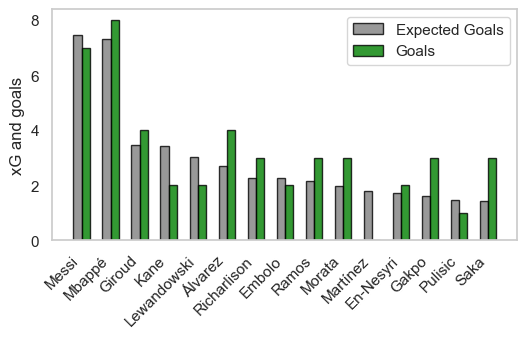

In [223]:
df_top10 = aggregated_data.sort_values(by='xG', ascending=False).head(15)
df_top10['last_name'] = df_top10['player_name_short'].apply(lambda x: x.split()[-1])



plt.figure(figsize=(6, 3))

# Set up the bar widths and positions
ind = np.arange(len(df_top10))  # the x locations for the groups

width = 0.28  # the width of the bars

# Create bars for expected goals
plt.bar(ind - width/2, df_top10['xG'], width, label='Expected Goals', color='grey', edgecolor= 'black', alpha=0.8)

# Create bars for actual goals
plt.bar(ind + width/2, df_top10['Goal'], width, label='Goals', color='green', edgecolor= 'black', alpha=0.8)

# Add titles and labels
plt.ylabel('xG and goals')
plt.xticks(ind, df_top10['last_name'], rotation=45)

# Set y-axis labels to display as integers
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:.0f}'.format(x)))


# Adjust the tick position
for tick in plt.gca().get_xticklabels():
    tick.set_horizontalalignment('right')

plt.legend(loc='best')
plt.grid(False)

# Show the plot
plt.show()

It is also interesting to look at the xGs from players with the most goals and shots

## 8.3.2 Expected goals vs players with most goals<a id="player_performance_12"></a>             

In [224]:
aggregated_data_goals = aggregated_data.sort_values(by='Goal', ascending=False)
df_top10_goals = aggregated_data_goals.head(15) 
df_top10_goals

print("Expected Goals vs Goals:")
df_top10_goals[['player_name_short', 'xG', 'Goal']]

Expected Goals vs Goals:


,player_name_short,xG,Goal
0,Kylian Mbappé,7.322737,8
1,Lionel Messi,7.463104,7
2,Olivier Giroud,3.473218,4
3,Julián Álvarez,2.710489,4
9,Álvaro Morata,1.983852,3
13,Cody Gakpo,1.605565,3
22,Bukayo Saka,1.439091,3
7,Gonçalo Ramos,2.164469,3
4,Richarlison,2.270476,3
19,Robert Lewandowski,3.017836,2


## 8.3.3 Expected goals vs players with most shots<a id="player_performance_123"></a>             

In [225]:
aggregated_data_shots = aggregated_data.sort_values(by='shots', ascending=False)
df_top10_shots = aggregated_data_shots.head(15) 
print("Expected Goals vs Shots:")
df_top10_shots[['player_name_short', 'xG', 'shots']]

Expected Goals vs Shots:


,player_name_short,xG,shots
0,Kylian Mbappé,7.322737,29
1,Lionel Messi,7.463104,27
2,Olivier Giroud,3.473218,17
11,Lautaro Martínez,1.799323,14
12,Youssef En-Nesyri,1.729386,11
3,Julián Álvarez,2.710489,11
36,João Félix,0.974572,11
88,Cristiano Ronaldo,1.353045,10
32,Marco Asensio,1.063049,10
19,Robert Lewandowski,3.017836,10


## 8.3.4 Over and underperformers<a id="player_performance_3"></a>             

In order to identify over and underperformers we decided to look at the xG per 90 minutes for each player and compare it with the goals per 90 minutes. The dataset which contains the minutes played for each player is available on Kaggle <a href="#ref7">[8]</a> and is based on data from https://fbref.com/de/. In the end we decided to only look at players who played at least 4 games during the World Cup + one hour on average per game, and therefore had a bigger chance to prove themself. For that we calculate the number of times each player has played first, add it to our existing dataset and then merged it with the data, which contains information about the minutes played. Lastly, we calculate the corresponding metrics and the performance difference. 

In [71]:
player_match_counts = all_events.groupby('player')['match_id'].nunique() # number of times each player has participated in a different match
player_match_counts_df = player_match_counts.reset_index()
player_match_counts_df.columns = ['player', 'Matches_Played']
aggregated_data = pd.merge(aggregated_data, player_match_counts_df, on='player', how='left')

In [72]:
players_minutes_played = pd.read_csv('player_stats.csv', delimiter=',')
aggregated_data = pd.merge(aggregated_data, players_minutes_played[['player', 'minutes']],
                         left_on='player_name_short', right_on='player', how='left')

In [85]:
df_top10 = aggregated_data.head(10) 
df_top10['xG/90'] = (df_top10['xG'] / df_top10['minutes']) * 90
df_top10['goals/90'] = (df_top10['Goal'] / df_top10['minutes']) * 90
df_top10['Performance_Difference'] = df_top10['Goal'] - df_top10['xG']
df_top10 = df_top10.sort_values(by='Performance_Difference', ascending=False)
print("Summary for players with highest xG")
df_top10[['player_name_short', 'Matches_Played', 'minutes', 'xG', 'Goal', 'xG/90', 'goals/90', 'Performance_Difference']]

Summary for players with highest xG


,player_name_short,Matches_Played,minutes,xG,Goal,xG/90,goals/90,Performance_Difference
3,Julián Álvarez,7,464.0,2.710489,4,0.525741,0.775862,1.289511
9,Álvaro Morata,4,185.0,1.983852,3,0.965117,1.459459,1.016148
7,Gonçalo Ramos,4,152.0,2.164469,3,1.281593,1.776316,0.835531
6,Marcus Rashford,5,140.0,2.164610,3,1.391535,1.928571,0.835390
4,Richarlison,4,323.0,2.270476,3,0.632640,0.835913,0.729524
0,Kylian Mbappé,7,598.0,7.322737,8,1.102084,1.204013,0.677263
2,Olivier Giroud,6,419.0,3.473218,4,0.746037,0.859189,0.526782
8,Niclas Füllkrug,3,69.0,2.029309,2,2.646925,2.608696,-0.029309
5,Breel Embolo,4,323.0,2.240877,2,0.624393,0.557276,-0.240877
1,Lionel Messi,7,690.0,7.463104,7,0.973448,0.913043,-0.463104


In [53]:
aggregated_data['minutes_per_game'] = (aggregated_data['minutes'] / aggregated_data['Matches_Played'])
aggregated_data = aggregated_data[aggregated_data['Matches_Played'] > 3]
#aggregated_data = aggregated_data[aggregated_data['minutes'] > 180]

aggregated_data = aggregated_data[aggregated_data['minutes_per_game'] > 30]

aggregated_data['xG/90'] = (aggregated_data['xG'] / aggregated_data['minutes']) * 90
aggregated_data['goals/90'] = (aggregated_data['Goal'] / aggregated_data['minutes']) * 90

In [54]:
aggregated_data['Performance_Difference'] = aggregated_data['goals/90'] - aggregated_data['xG/90']
top_overperformers = aggregated_data.sort_values(by='Performance_Difference', ascending=False).head(5)
top_underperformers = aggregated_data.sort_values(by='Performance_Difference', ascending=True).head(3)

In [55]:
# Print the results
print("Top 5 overperformers:")
top_overperformers[['player_name_short', 'Matches_Played', 'xG', 'minutes', 'Goal', 'xG/90', 'goals/90']]

Top 5 overperformers:


,player_name_short,Matches_Played,xG,minutes,Goal,xG/90,goals/90
7,Gonçalo Ramos,4,2.164469,152.0,3,1.281593,1.776316
9,Álvaro Morata,4,1.983852,185.0,3,0.965117,1.459459
22,Bukayo Saka,4,1.439091,288.0,3,0.449716,0.937500
42,Ritsu Doan,4,0.915805,217.0,2,0.379827,0.829493
13,Cody Gakpo,5,1.605565,450.0,3,0.321113,0.600000


In [56]:
# Print the results
print("Top 3 underperformers:")
top_underperformers[['player_name_short', 'Matches_Played', 'xG', 'minutes', 'Goal', 'xG/90', 'goals/90']]

Top 3 underperformers:


,player_name_short,Matches_Played,xG,minutes,Goal,xG/90,goals/90
11,Lautaro Martínez,6,1.799323,241.0,0,0.671946,0.000000
10,Harry Kane,5,3.432043,402.0,2,0.768368,0.447761
19,Robert Lewandowski,4,3.017836,360.0,2,0.754459,0.500000


## 8.3.5 Market value adjustments vs expected goals<a id="player_performance_5"></a>             

Now we will look at possible market value updates for all the players we looked at during this performance analysis. Once again: The market value update only consisted of market value upgrades and Transfermarkt didn't downgrade any players with this update! Therefore we won't see any downgraded players in our analysis

In [57]:
df_top10= df_top10[['player_name_short', 'xG', 'Goal', 'market_value_change']]
top_overperformers= top_overperformers[['player_name_short', 'xG', 'Goal', 'market_value_change']]
top_underperformers= top_underperformers[['player_name_short', 'xG', 'Goal', 'market_value_change']]

In [58]:
combined_df = pd.concat([top_overperformers, top_overperformers, df_top10], ignore_index=True)
combined_df = combined_df.drop_duplicates()
combined_df_sorted = combined_df.sort_values(by='market_value_change', ascending=False)
combined_df_sorted['market_value_change'] = combined_df_sorted['market_value_change'] / 1000000 # better readability if it is in million

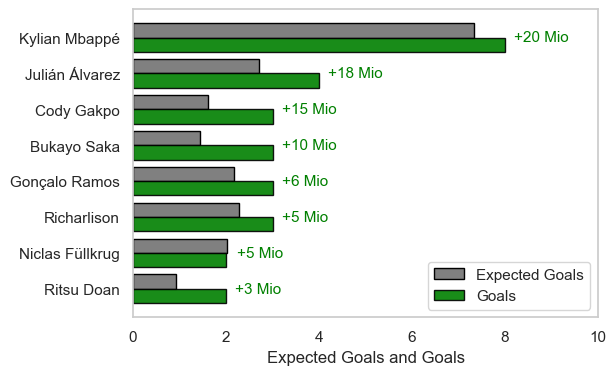

In [59]:
df_top10_plot = combined_df_sorted.dropna()

plt.figure(figsize=(6, 4))
ind = np.arange(len(df_top10_plot))
width = 0.40  # Bar width

# Plotting xG bars (base)
xg_bars = plt.barh(ind, df_top10_plot['xG'], height=width, color='grey', alpha=1, edgecolor='black', label='Expected Goals')

goals_bars = plt.barh(ind + width, df_top10_plot['Goal'], height=width, color='green', edgecolor='black', alpha=0.9, label='Goals')

plt.xlabel('Expected Goals and Goals')
plt.yticks(ind + width / 2, df_top10_plot['player_name_short'])  

max_width = max(max(df_top10_plot['xG']), max(df_top10_plot['Goal'])) + max(abs(df_top10_plot['market_value_change'])) / 10

for i, (xg_bar, goal_bar, value_change) in enumerate(zip(xg_bars, goals_bars, df_top10_plot['market_value_change'])):
    max_bar_width = max(xg_bar.get_width(), goal_bar.get_width())

    if value_change > 0:
        value_text = f'+{int(value_change)} Mio'
        color = 'green'
    else:
        value_text = f'{int(value_change)} Mio'
        color = 'red'
    
    plt.text(max_bar_width + 0.2, ind[i] + width / 2, value_text, va='center', color=color, fontsize=11)

plt.gca().invert_yaxis()
plt.xlim(0, max_width) 
plt.grid(False)
plt.legend()
plt.show()

## 8.3.1 Players with the highest expected goals<a id="player_performance_1"></a>             

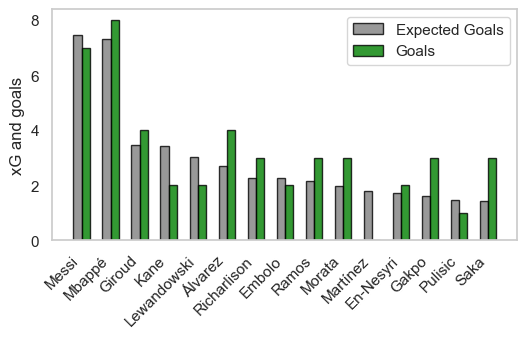

In [322]:
df_top10 = aggregated_data.sort_values(by='xG', ascending=False).head(15)
df_top10['last_name'] = df_top10['player_name_short'].apply(lambda x: x.split()[-1])



plt.figure(figsize=(6, 3))

# Set up the bar widths and positions
ind = np.arange(len(df_top10))  # the x locations for the groups

width = 0.28  # the width of the bars

# Create bars for expected goals
plt.bar(ind - width/2, df_top10['xG'], width, label='Expected Goals', color='grey', edgecolor= 'black', alpha=0.8)

# Create bars for actual goals
plt.bar(ind + width/2, df_top10['Goal'], width, label='Goals', color='green', edgecolor= 'black', alpha=0.8)

# Add titles and labels
plt.ylabel('xG and goals')
plt.xticks(ind, df_top10['last_name'], rotation=45)

# Set y-axis labels to display as integers
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:.0f}'.format(x)))


# Adjust the tick position
for tick in plt.gca().get_xticklabels():
    tick.set_horizontalalignment('right')

plt.legend(loc='best')
plt.grid(False)

# Show the plot
plt.show()

## 8.3.2 Expected goals vs players with most goals<a id="player_performance_12"></a>             

In [323]:
df_top10_goals = df_top10.sort_values(by='Goal', ascending=False).head(15)
df_top10_goals
print("Expected Goals vs actual goals:")
df_top10_goals[['player_name_short', 'xG', 'Goal']]

Expected Goals vs actual goals:


,player_name_short,xG,Goal
0,Kylian Mbappé,7.322737,8
1,Lionel Messi,7.463104,7
2,Olivier Giroud,3.473218,4
3,Julián Álvarez,2.710489,4
4,Richarlison,2.270476,3
7,Gonçalo Ramos,2.164469,3
9,Álvaro Morata,1.983852,3
13,Cody Gakpo,1.605565,3
22,Bukayo Saka,1.439091,3
10,Harry Kane,3.432043,2


## 8.3.3 Expected goals vs players with most shots<a id="player_performance_123"></a>             

In [324]:
df_top10_goals = df_top10.sort_values(by='shots', ascending=False).head(15)
df_top10_goals
print("Expected Goals vs shots:")
df_top10_goals[['player_name_short', 'xG', 'shots']]

Expected Goals vs shots:


,player_name_short,xG,shots
0,Kylian Mbappé,7.322737,29
1,Lionel Messi,7.463104,27
2,Olivier Giroud,3.473218,17
11,Lautaro Martínez,1.799323,14
3,Julián Álvarez,2.710489,11
12,Youssef En-Nesyri,1.729386,11
10,Harry Kane,3.432043,10
19,Robert Lewandowski,3.017836,10
20,Christian Pulisic,1.444115,9
4,Richarlison,2.270476,8


## 8.3.4 Over and underperformers<a id="player_performance_3"></a>             

In [329]:
df_top10['xG/90'] = (df_top10['xG'] / df_top10['minutes']) * 90
df_top10['Performance_Difference'] = df_top10['Goal'] - df_top10['xG']
df_top10_overperformers = df_top10.sort_values(by='Performance_Difference', ascending=False).head(3)
print("Top 3 overperformers")
df_top10_overperformers[['player_name_short', 'minutes', 'shots' ,'Goal', 'xG', 'xG/90', 'Performance_Difference']]

Top 3 overperformers


,player_name_short,minutes,shots,Goal,xG,xG/90,Performance_Difference
22,Bukayo Saka,288.0,7,3,1.439091,0.449716,1.560909
13,Cody Gakpo,450.0,5,3,1.605565,0.321113,1.394435
3,Julián Álvarez,464.0,11,4,2.710489,0.525741,1.289511


In [330]:
df_top10_underperformers = df_top10.sort_values(by='Performance_Difference', ascending=True).head(3)
print("Top 3 underperformers")
df_top10_underperformers[['player_name_short', 'minutes', 'shots' ,'Goal', 'xG', 'xG/90', 'Performance_Difference']]

Top 3 underperformers


,player_name_short,minutes,shots,Goal,xG,xG/90,Performance_Difference
11,Lautaro Martínez,241.0,14,0,1.799323,0.671946,-1.799323
10,Harry Kane,402.0,10,2,3.432043,0.768368,-1.432043
19,Robert Lewandowski,360.0,10,2,3.017836,0.754459,-1.017836


## 8.3.5 Market value adjustments vs expected goals<a id="player_performance_5"></a>             

In [327]:
combined_df = pd.concat([df_top10_overperformers, df_top10_underperformers, df_top10], ignore_index=True)
combined_df = combined_df.drop_duplicates()
combined_df_sorted = combined_df.sort_values(by='market_value_change', ascending=False)
combined_df_sorted['market_value_change'] = combined_df_sorted['market_value_change'] / 1000000 # better readability if it is in million

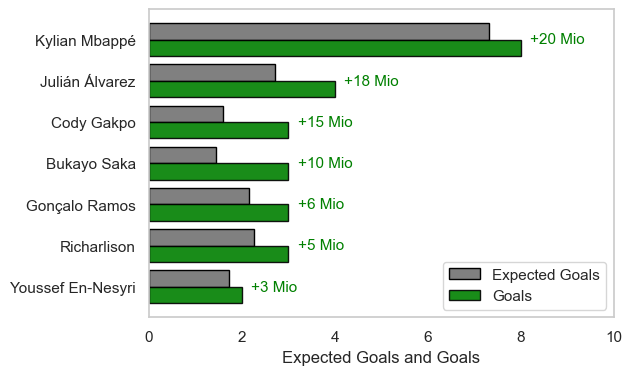

In [328]:
df_top10_plot = combined_df_sorted.dropna() # by dropping nans, we ensure that we only include players with market value change

plt.figure(figsize=(6, 4))
ind = np.arange(len(df_top10_plot))
width = 0.40  # Bar width

# Plotting xG bars (base)
xg_bars = plt.barh(ind, df_top10_plot['xG'], height=width, color='grey', alpha=1, edgecolor='black', label='Expected Goals')

goals_bars = plt.barh(ind + width, df_top10_plot['Goal'], height=width, color='green', edgecolor='black', alpha=0.9, label='Goals')

plt.xlabel('Expected Goals and Goals')
plt.yticks(ind + width / 2, df_top10_plot['player_name_short'])  

max_width = max(max(df_top10_plot['xG']), max(df_top10_plot['Goal'])) + max(abs(df_top10_plot['market_value_change'])) / 10

for i, (xg_bar, goal_bar, value_change) in enumerate(zip(xg_bars, goals_bars, df_top10_plot['market_value_change'])):
    max_bar_width = max(xg_bar.get_width(), goal_bar.get_width())

    if value_change > 0:
        value_text = f'+{int(value_change)} Mio'
        color = 'green'
    else:
        value_text = f'{int(value_change)} Mio'
        color = 'red'
    
    plt.text(max_bar_width + 0.2, ind[i] + width / 2, value_text, va='center', color=color, fontsize=11)

plt.gca().invert_yaxis()
plt.xlim(0, max_width) 
plt.grid(False)
plt.legend()
plt.show()

# <strong>References<a id="references"></a><strong>

- <a id="ref1">[1]</a> David Sumpter. Should you write about real goals or expected goals? A guide for journalists. Medium, November 2017.

- <a id="ref2">[2]</a> Jonny Whitmore. What is expected goals (xg)? Opta Analyst, August 2023.

- <a id="ref3">[3]</a> Statsbomb: Football data, 2024. Url: https://github.com/statsbomb/statsbombpy, Accessed: 2024-01-13.

- <a id="ref4">[4]</a> David Sumpter. The geometry of shooting. 2017. URL: https://soccermatics.medium.com/the-geometry-of-shooting-ae7a67fdf760

- <a id="ref5">[5]</a> David Sumpter, Aleksander Andrzejewski. Expected Goals including player positions. 2017. URL: 
https://soccermatics.readthedocs.io/en/latest/gallery/lesson7/plot_xG_tracking.html

- <a id="ref6">[6]</a> Derrick Yam. Closing down: How defensive pressure impacts shots. Stats- Bomb Inc., September 2018. URL: https://statsbomb.com/articles/soccer/closing-down-how-defensive-pressure-impacts-shots/

- <a id="ref6">[7]</a> David Cariboo. Football Data from Transfermarkt. 2024. URL: https://www.kaggle.com/datasets/davidcariboo/player-scores

- <a id="ref7">[8]</a> FIFA World Cup 2022 Player Data. 2022 URL: https://www.kaggle.com/datasets/swaptr/fifa-world-cup-2022-player-data?select=player_stats.csv